# <center>Ultimate 25k+ Matches Football Database
    
    
<div align="center" margin-top: 0px;>
        <img src="https://cdn2.iconfinder.com/data/icons/iconslandsport/PNG/256x256/Soccer_Ball.png" alt="Picture of a football">
</div>
    

## <center>Exploratory Data Analysis and Result Prediction via ML

Given an difficult dataset with no logic and congruence in data arrangement inside columns, our goal is to arrange the data properly and run EDA on it, further using the data to make some useful observations and prediction.

In [1]:
!mkdir -p csv
!mkdir -p pandasprofiling
!pip install -q pandas-profiling
!pip install -q sklearn
!pip install -q requests
!pip install -q tabulate
!pip install -q future
!pip install -q tpot
!pip install -q torch torchvision

In [2]:
# !pip install -q -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from xml.etree.ElementTree import fromstring, ElementTree
from IPython.core.display import HTML
import sqlite3
import sys
import seaborn as sns
import lxml.etree as ET

### Data Loading

The dataset is stored in a sqlite database, so we need to connect to that database, query the available tables, and import them as a pandas Dataframe.

Important Note: The SQL database is mapped according to docker compose initialzed container. Change the address according to you environment requirements.

### Fetch dfs from tables into a dictionary for easy assignment

In [4]:
import os

file_path = '/notebooks/database.sqlite'

if not os.path.exists(file_path):
    print(f"{file_path} does not exist. \nDatabase can be downloaded from https://www.kaggle.com/prajitdatta/ultimate-25k-matches-football-database-european\nKindly download it, extract it from the zip file and place it in the base folder of this notebook as database.sqlite file\n \033[1;31;5;91mKindly import the database file before proceeding \033[0m\n\n")
    sys.exit(1)

In [5]:
with sqlite3.connect("/notebooks/database.sqlite") as conn:
    cursor = conn.cursor()

football_db = {}

# List of tables in the database
result = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")

# For each table we extract its data and create a dataframe
for table in result:
    query = "SELECT * from {};".format(table[0])
    football_db[table[0]] = pd.read_sql_query(query, conn)
    # export to csv
    football_db[table[0]].to_csv(f"./csv/{table[0]}.csv", index=False)

print(f"Successfully extracted data from the following tables: \n \t{football_db.keys()}")

Successfully extracted data from the following tables: 
 	dict_keys(['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes'])


In [6]:
# print the first 5 rows of the table
print(football_db['sqlite_sequence'])

# print the shape of the table
print(football_db['sqlite_sequence'].shape)

                name     seq
0               Team  103916
1            Country   51958
2             League   51958
3              Match   51958
4             Player   11075
5  Player_Attributes  183978
6    Team_Attributes    1458
(7, 2)


The table sqlite_sequence is a special table in SQLite that is used to store the last used value of an AUTOINCREMENT field for each table. It is not a user-defined table and is not related to the data in your database.

We can ignore sqlite_sequence and make a dataframe each for storing each other table as a df.

### <center>Look at dataframes</center>

We make a copy of each df from dictionary and so that we do not affect this source of truth while playing with data.

In [7]:
df_team = football_db["Team"].copy()
df_country = football_db["Country"].copy()
df_league = football_db["League"].copy()
df_match = football_db["Match"].copy()
df_player = football_db["Player"].copy()
df_player_attr = football_db["Player_Attributes"].copy()
df_team_attr = football_db["Team_Attributes"].copy()

Look at the heads and shapes of each dataframe to get a sense of data.

In [8]:
df_team.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [9]:
df_country.head()

id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy

In [10]:
df_league.head()

id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A

In [11]:
df_match.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 115 columns]

In [12]:
df_player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [13]:
df_player_attr.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   ...  vision  penalties  marking  standing_tackle  sliding_tackle  \
0  ...    54.0       48.0     65.0             69.0            69.0   
1  ...    54.0       48.0     65.0             69.0            69.0   
2  ...    54.0       48.0     65.0             66.0            69.0   
3  ...    53.0       47.0     62.0             63.0            66.0   
4  ...    53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [14]:
df_team_attr.head()

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting  \
0                  50                   Mixed  ...                     55   
1                  56                   Mixed  ...                     64   
2                  54                   Mixed  ...                     64   
3                  70                    Long  ...                     70   
4                  52                   Mixed  ...                     52   

   chanceCreationShootingClass chanceCreationPositioningClass  \
0                       Normal                      Organised   
1                       Normal                      Organised   
2                       Normal                      Organised   
3                         Lots                      Organised   
4                       Normal                      Organised   

   defencePressure defencePressureClass  defenceAggression  \
0               50               Medium                 55   
1               47               Medium                 44   
2               47               Medium                 44   
3               60               Medium                 70   
4               47               Medium                 47   

  defenceAggressionClass defenceTeamWidth  defenceTeamWidthClass  \
0                  Press               45                 Normal   
1                  Press               54                 Normal   
2                  Press               54                 Normal   
3                 Double               70                   Wide   
4                  Press               52                 Normal   

  defenceDefenderLineClass  
0                    Cover  
1                    Cover  
2                    Cover  
3                    Cover  
4                    Cover  

[5 rows x 25 columns]

### Look into heads, we find api fields which can be huge data-enrichers.

There are some api fields in many dfs, so we check if they work and we can enrich our data with this goldmine.

We registered to the FIFA website at https://futdb.app/api/doc and we found that the API is not working on the free version.

Moreover, on the FIFA api, many api endpoints are even missing, for example, the match api endpoints are missing. 
We can say that the API structure as well as data identifiers (ids) have changed.

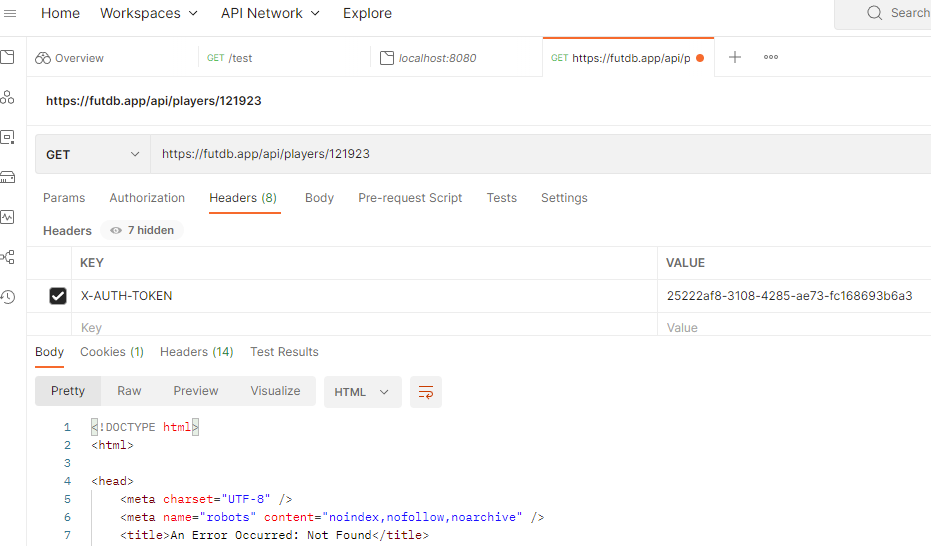

In [15]:
# show image here from the same folder as the one this file is in
Image.open("/notebooks/images/APIresponse2023-01-06 163243.png")

Next, we get the dimensions of each dataframe.

<br /><br /><br />
### The data we have been given is old, and the new FIFA Api does not recogize the idetifiers (ids). So there is no method left with us to verify or enrich against FIFA API. We have to assume that the data is sane. Plus, we drop these unuseful columns.
<br /><br /><br />

Also there is no benefit of API coulmns if we are unable to get information from there. So we drop these columns from all datasets.

Before dropping, we need to see if these API fields can act as unique identifiers. If yes, we will keep them as id identifiers or match and replace them accrodingly to have cross table references.

In [16]:
# how many unique team api ids are there?
print(df_team["team_api_id"].nunique())
# how many unique team fifa api id's are there?
print(df_team["team_fifa_api_id"].nunique())
# how many unique team_long_name are there?
print(df_team["team_long_name"].nunique())

299
285
296


In [17]:
# are there any teams that have the same team_long_name but different team_api_id?
df_team.groupby("team_long_name").agg({"team_api_id": "nunique"}).sort_values(by="team_api_id", ascending=False).head()

team_api_id
team_long_name                   
Royal Excel Mouscron            2
Widzew Łódź                     2
Polonia Bytom                   2
Parma                           1
Partick Thistle F.C.            1

In [18]:
# print the different team_long_names for a team with the same team_api_id
df_team[df_team["team_long_name"] == "Royal Excel Mouscron"].sort_values(by="team_api_id")

id  team_api_id  team_fifa_api_id        team_long_name team_short_name
15    16         9996          111560.0  Royal Excel Mouscron             MOU
24  2510       274581          111560.0  Royal Excel Mouscron             MOP

In [19]:
# are there any teams that have the same team_long_name but different team_fifa_api_id?
df_team.groupby("team_long_name").agg({"team_fifa_api_id": "nunique"}).sort_values(by="team_fifa_api_id", ascending=False).head()

team_fifa_api_id
team_long_name                             
1. FC Kaiserslautern                      1
Korona Kielce                             1
RC Deportivo de La Coruña                 1
RC Celta de Vigo                          1
RAEC Mons                                 1

### Based on the above analysis of columns of team_api_id and team_api_fifa_id, we can drop team_api_id.

Also we observe that a team has different short name and same long name, this is unacceptable.

At this moment, we just drop the team short name as it is not present in any other data-set and is not reliable even.

In [20]:
# drop the column team_api_id since it is not unique to the team
df_team.drop("team_api_id", axis=1, inplace=True)
# drop the column team_short_name since it is not unique to the team
df_team.drop("team_short_name", axis=1, inplace=True)

In [21]:
# drop the column league_id as it is not needed
df_match.drop(columns=["league_id"],inplace=True)
df_match.head()

id  country_id     season  stage                 date  match_api_id  \
0   1           1  2008/2009      1  2008-08-17 00:00:00        492473   
1   2           1  2008/2009      1  2008-08-16 00:00:00        492474   
2   3           1  2008/2009      1  2008-08-16 00:00:00        492475   
3   4           1  2008/2009      1  2008-08-17 00:00:00        492476   
4   5           1  2008/2009      1  2008-08-16 00:00:00        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  ...  \
0              9987              9993               1               1  ...   
1             10000              9994               0               0  ...   
2              9984              8635               0               3  ...   
3              9991              9998               5               0  ...   
4              7947              9985               1               3  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 114 columns]

In [22]:
df_team.shape

(299, 3)

In [23]:
df_country.shape

(11, 2)

In [24]:
df_league.shape

(11, 3)

In [25]:
df_match.shape

(25979, 114)

In [26]:
df_player.shape

(11060, 7)

In [27]:
df_player_attr.shape

(183978, 42)

In [28]:
df_team_attr.shape

(1458, 25)

### <center>Verify that there is indeed no duplicate data is there in the dataset</center>

In [29]:
# cehck if there are any duplicate rows anywhere in the data
print(df_team.duplicated().sum())
print(df_country.duplicated().sum())
print(df_league.duplicated().sum())
print(df_match.duplicated().sum())
print(df_player.duplicated().sum())
print(df_player_attr.duplicated().sum())
print(df_team_attr.duplicated().sum())

0
0
0
0
0
0
0


Each dataset may have their own unique identifier. We can use that to verify that there is no duplicate data in the dataset by checking those identifiers later.

## <center>Player

In [30]:
df_player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

A player is unique by his name and birthday. We are assuming that this set is a unique indetifier to look for data incongruence.
Let's check for data congruency.

In [31]:
df_player[df_player.duplicated(subset=['player_name','birthday'],keep=False)]

Empty DataFrame
Columns: [id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight]
Index: []

In [32]:
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 900)

df_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


Columns can be identified as follows:

- id: Instance identifier
- player_api_id: Identifier of the player in the API used
- player_name: Player's name
- player_fifa_api_id: Identifier of the player in the FIFA API
- birthday: Player's date of birth
- height: Player's height in centimeters
- weight: Player's weight in pounds

As we see in the previous description, we have many fields that perform the task of identifying the instances, so we are going to choose the most useful one to work with the dataset. In this case, we can remove the id and player_fifa_api_id fields and use the player_api_id attribute to identify the players. We will put this last attribute as the index of the dataset.

In [33]:
df_player.drop(columns=["id", "player_fifa_api_id"],inplace=True)

In [34]:
df_player.set_index('player_api_id', inplace=True)

In [35]:
df_player.head()

player_name             birthday  height  weight
player_api_id                                                         
505942         Aaron Appindangoye  1992-02-29 00:00:00  182.88     187
155782            Aaron Cresswell  1989-12-15 00:00:00  170.18     146
162549                Aaron Doran  1991-05-13 00:00:00  170.18     163
30572               Aaron Galindo  1982-05-08 00:00:00  182.88     198
23780                Aaron Hughes  1979-11-08 00:00:00  182.88     154

We'll start with the birthday attribute that represents the players' date of birth. As we can see, it is indicated in year, month and day format, which is too much information to solve this problem. Therefore, we are going to modify this attribute so that it only includes the year.

In [36]:
df_player["birthday"] = pd.DatetimeIndex(df_player["birthday"]).year

If we analyze the year of birth of the players, we can conclude that this variable follows a distribution skewed to the right. Furthermore, we can conclude that the majority of players were born between 1985 and 1990.

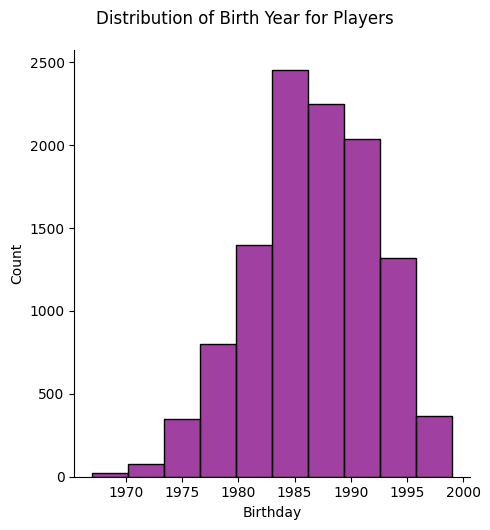

In [37]:
import seaborn as sns

# Create the plot
g = sns.displot(df_player, x="birthday", bins=10, color='purple')

# Add the title
g.fig.suptitle("Distribution of Birth Year for Players", y=1.05)

# Rename the x axis label
g.set(xlabel='Birthday')
plt.show()

If we analyze the weight and height data, we see the following:
- Weight: The average would be about 76Kg while the maximum and minimum would be 110Kg and 53Kg respectively.
- Height: The average would be about 181cm while the maximum and minimum would be 208cm and 157cm respectively.

In [38]:
df_player[["height","weight"]].describe()

height        weight
count  11060.000000  11060.000000
mean     181.867445    168.380289
std        6.369201     14.990217
min      157.480000    117.000000
25%      177.800000    159.000000
50%      182.880000    168.000000
75%      185.420000    179.000000
max      208.280000    243.000000

In both cases, we can see that the variables represent a normal distribution.

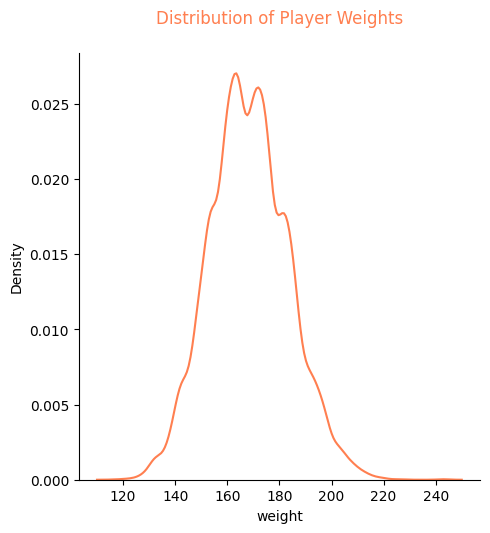

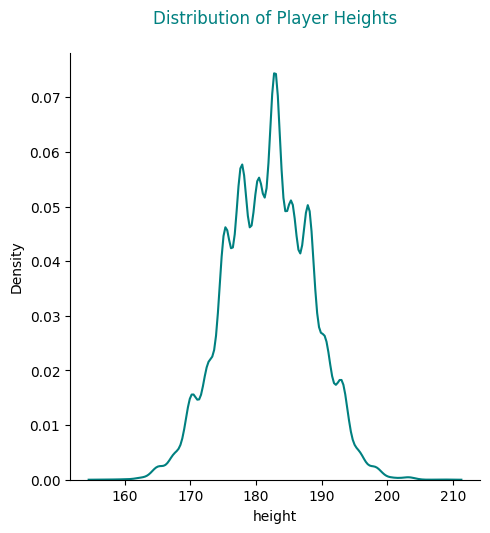

In [39]:
sns.displot(df_player, x="weight",kind="kde", color="coral")
plt.title("Distribution of Player Weights", color="coral", y=1.05)

sns.displot(df_player, x="height",kind="kde", color="teal")
plt.title("Distribution of Player Heights", color="teal", y=1.05)
plt.show()

We can also see a positive relationship between both variables, that is, the greater the height, the greater the weight of the soccer players.

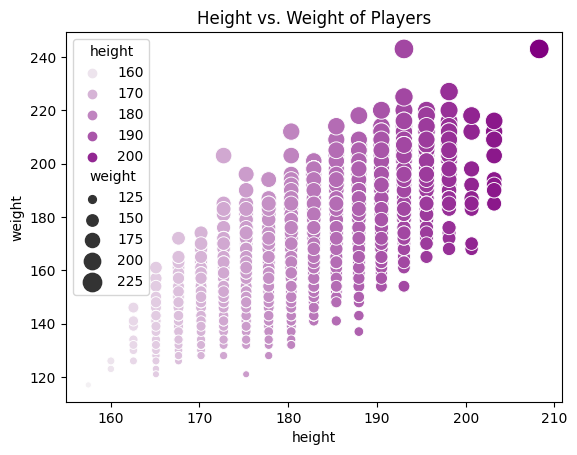

In [40]:
sns.scatterplot(data=df_player, x="height", y="weight", size="weight", sizes=(20,200), hue="height", palette=sns.light_palette("purple", as_cmap=True))
plt.title("Height vs. Weight of Players")
plt.show()

One way to combine these two units into a single one would be to use the Body Mass Index (BMI) metric. In the following bar chart it can be seen that the BMI of the players follows a normal distribution, with the center of the distribution being around the value 23.
Convert from pounds to kilograms by dividing it by 2.205, and convert height from inches to meters by dividing it by 100.0 and then squaring the result.

In [41]:
df_player["BMI"] = (df_player["weight"] / 2.205) / ((df_player["height"] / 100.0) ** 2)

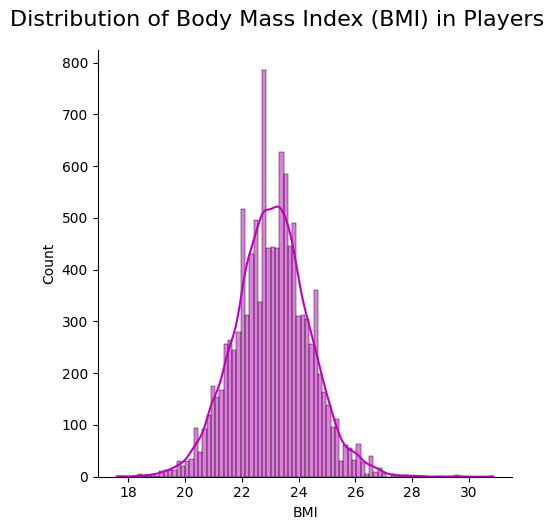

In [42]:
import matplotlib.pyplot as plt

title = "Distribution of Body Mass Index (BMI) in Players"

g = sns.displot(df_player, x="BMI", kde=True, color="m", label="BMI")

plt.suptitle(title, y=1.05, fontsize=16)

plt.show()

With the BMI variable generated by combining the weight and height attributes, we could do without these two attributes. Additionally, we have seen that we have two identifiers for the players: player_api_id and player_fifa_api_id so we can also remove one of them. In this case, it is preferable to keep the player_api_id attribute because it appears more frequently in other datasets.

In [43]:
df_player.drop(columns=["weight","height"],inplace=True)

## Player attributes

The following dataset contains a series of attributes for soccer players, which have been extracted from the FIFA video game. In general, an attribute is nothing more than an ability that a player possesses and whose value is in a range of 0 to 99. The average rating for these attributes is reflected in the overall_rating field. The higher the value of these attributes, the better the player's ability.

Specifically, we can classify the value of an attribute with the following quality labels:

- Excellent: 90 - 99 
- Very Good: 80 - 89 
- Good: 70 - 79 
- Fair: 50 - 69 
- Poor: 40 - 49 
- Very Poor: 0 - 39

In [44]:
df_player_attr.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   ...  vision  penalties  marking  standing_tackle  sliding_tackle  \
0  ...    54.0       48.0     65.0             69.0            69.0   
1  ...    54.0       48.0     65.0             69.0            69.0   
2  ...    54.0       48.0     65.0             66.0            69.0   
3  ...    53.0       47.0     62.0             63.0            66.0   
4  ...    53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

Regarding the size of the dataset, we have 183978 instances and 41 predictor variables.

In [45]:
df_player_attr.shape

(183978, 42)

In [46]:
df_player_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

Regarding the description of the attributes, we have collected the following information:

1. player_fifa_api_id: Player identifier in the FIFA video game API
2. player_api_id: Player identifier in the API used
3. date: Date of the observation
4. overall_rating: Average player skill score
5. potential: It is an estimate that indicates what the maximum overall_rating of a player will be during his professional career.
6. preferred_foot: It indicates which leg the player tends to play with and, consequently, the one on which he has greater power and control of the ball.
7. attacking_work_rate: The work rates indicate the level of involvement or participation of a player in attacking movements. These attributes can have values ​​high, medium and low.
8. defensive_work_rate: The work rates indicate the level of involvement or participation of a player in defensive movements. These attributes can have values ​​high, medium and low.
9. crossing: Determines the quality and accuracy of a player making a pass towards the center of the field, close to the opponent's goal.
10. finishing: Indicates the player's ability to score a goal.
11. heading_accuracy: Sets the player's accuracy in passing or clearing the ball using their head.
12. short_passing: Player's ability to make short passes
13. volleys: This skill demonstrates a player's ability to take shots or passes while the ball is in the air.
14. dribbling: Evaluates the ability to maintain possession of the ball against an opponent. This metric primarily measures the player's dribbling prowess.
15. curve: This attribute measures the player's ability to make passes or shots with a curved trajectory.
16. free_kick_accuracy: Accuracy or skill of the player in free kicks.
17. long_passing: Player's ability to make long passes.
18. ball_control: Level of player control over the ball.
19. acceleration: Player's ability to accelerate quickly.
20. sprint_speed: Player's ability to run at maximum speed.
21. agility: Player's ability to change direction quickly.
22. reactions: Player's response time to events that happen around him.
23. balance: Shows the player's balance level.
24. shot_power: This attribute determines the power of a player to shoot the ball with power.
25. jumping: Player's ability to jump.
26. stamina: Player's ability to maintain high levels of physical performance for long periods of time.
27. strength: Player's ability to resist physical contact. It shows what is the physical strength of a player.
28. long_shots: Player's ability to shoot from a long distance.
29. aggression: Measures the frequency of pushing, pulling and tackling members of the opposing team.
30. interceptions: Player's ability to intercept the ball. Ability to intercept the ball during passes from the opposing team.
31. positioning: Player's ability to find the best position in the field to receive the ball.
32. vision: Player's ability to see the game and make good decisions. Also, Mental ability of the player to remember the positions of his teammates.
33. penalties: Accuracy of the player to take penalties.
34. marking: Ability to defend against a play by the opposing team.
35. standing_tackle: Ability of the player to make tackles, that is, to extend the leg to move the ball away from the opponent.
36. sliding_tackle: Ability of the player to make tackles, that is, to extend the leg to move the ball away from the opponent. A standing/block tackle as its name implies is one where you remain on your feet. The other tackle is when you are off your feet, also known as the sliding tackle.
37. gk_diving: Goalkeeper's ability to dive to save shots.
38. gk_handling: Goalkeeper's ability to catch or stop the ball with his hands.
39. gk_kicking: Evaluate the length and accuracy of the goalkeeper's kicks.
40. gk_positioning: Goalkeeper's ability to position himself to save shots.
41. gk_reflexes: Goalkeeper's ability to react to save shots.

As we have done with the previous dataset, we remove the player_fifa_api_id and id attributes and keep the player_api_id attribute that will act as the dataset index.

In [47]:
df_player_attr.drop(columns = ["player_fifa_api_id", "id"],inplace=True)

First of all, we have discovered that there are instances with all their attributes with NA or null values, except for the variables player_fifa_api_id, player_api_id, date. Therefore, we are going to remove the instances that have a large percentage of missing values.

In [48]:
df_player_attr[df_player_attr["overall_rating"].isnull()].head()

player_api_id                 date  overall_rating  potential  \
483           31684  2007-02-22 00:00:00             NaN        NaN   
983           29904  2007-02-22 00:00:00             NaN        NaN   
1752          24159  2007-02-22 00:00:00             NaN        NaN   
2089          31916  2007-02-22 00:00:00             NaN        NaN   
2482          37249  2007-02-22 00:00:00             NaN        NaN   

     preferred_foot attacking_work_rate defensive_work_rate  crossing  \
483            None                None                None       NaN   
983            None                None                None       NaN   
1752           None                None                None       NaN   
2089           None                None                None       NaN   
2482           None                None                None       NaN   

      finishing  heading_accuracy  ...  vision  penalties  marking  \
483         NaN               NaN  ...     NaN        NaN      NaN   
983         NaN               NaN  ...     NaN        NaN      NaN   
1752        NaN               NaN  ...     NaN        NaN      NaN   
2089        NaN               NaN  ...     NaN        NaN      NaN   
2482        NaN               NaN  ...     NaN        NaN      NaN   

      standing_tackle  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
483               NaN             NaN        NaN          NaN         NaN   
983               NaN             NaN        NaN          NaN         NaN   
1752              NaN             NaN        NaN          NaN         NaN   
2089              NaN             NaN        NaN          NaN         NaN   
2482              NaN             NaN        NaN          NaN         NaN   

      gk_positioning  gk_reflexes  
483              NaN          NaN  
983              NaN          NaN  
1752             NaN          NaN  
2089             NaN          NaN  
2482             NaN          NaN  

[5 rows x 40 columns]

In [49]:
df_player_attr.isnull().sum()

player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving           

In [50]:
null_instances = df_player_attr[df_player_attr["overall_rating"].isnull()].index

In [51]:
df_player_attr.drop(null_instances,inplace=True)

This dataset seems to complement the attributes of the player dataset, so we can combine it into a single dataset.

In [52]:
df_player_attr = df_player.merge(df_player_attr,on=["player_api_id"])

A peculiarity of this dataset is that it contains information on the players by dates, that is, it shows us metrics of the players on different dates since they can vary over time. These dates are indicated in day, month and year format in the date field, which we are going to modify to show only the year. 

Additionally, we have seen that there are instances of player statistics within the same year, so we are going to simplify all this information into a single annual instance. In particular, we are going to obtain the mode of the non-numeric data and the mean of the numeric data.

In [53]:
df_player_attr["date"] =  pd.DatetimeIndex(df_player_attr["date"]).year

In [54]:
def break_ties(col: str):
    most_common = pd.Series.mode(col)
    
    if len(most_common) > 1:
        return most_common[0]
    else:
        return most_common

We obtain the mode for categorical data.

In [55]:
df_player_attr_cat = df_player_attr.groupby(["player_api_id", "date"])[["preferred_foot","attacking_work_rate", "defensive_work_rate"]].agg(lambda x: break_ties(x)).reset_index()

In [56]:
df_player_attr_cat.head()

player_api_id  date preferred_foot attacking_work_rate defensive_work_rate
0           2625  2007          right                high              medium
1           2625  2008          right                high              medium
2           2625  2010          right                high              medium
3           2625  2011          right                high              medium
4           2625  2012          right              medium              medium

We get the mean for numeric data.

In [57]:
df_player_attr_num = df_player_attr.groupby(["player_api_id", "date"]).agg("mean", numeric_only=True).reset_index()

In [58]:
df_player_attr_num.head()

player_api_id  date  birthday        BMI  overall_rating  potential  \
0           2625  2007    1981.0  22.737699            63.0       64.0   
1           2625  2008    1981.0  22.737699            60.0       64.0   
2           2625  2010    1981.0  22.737699            60.0       64.0   
3           2625  2011    1981.0  22.737699            58.5       60.5   
4           2625  2012    1981.0  22.737699            58.0       58.0   

   crossing  finishing  heading_accuracy  short_passing  ...  vision  \
0      48.0       48.0              47.0           64.0  ...    56.0   
1      48.0       48.0              47.0           64.0  ...    56.0   
2      48.0       48.0              47.0           64.0  ...    56.0   
3      52.0       47.0              46.0           58.0  ...    55.0   
4      52.0       47.0              46.0           53.0  ...    55.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       46.0     64.0             66.0            63.0       14.0   
1       46.0     64.0             66.0            63.0       14.0   
2       69.0     64.0             66.0            63.0       12.0   
3       66.0     63.0             63.0            57.0       12.0   
4       66.0     63.0             63.0            52.0       12.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         17.5        67.0            16.5         17.0  
1         24.0        67.0            24.0         24.0  
2         11.0         6.0             8.0          8.0  
3         11.0         6.0             8.0          8.0  
4         11.0         6.0             8.0          8.0  

[5 rows x 39 columns]

We create again a dataset of player attributes with the simplification done:

In [59]:
df_player_attr = df_player_attr_cat.merge(df_player_attr_num, on=["player_api_id","date"])

In [60]:
df_player_attr.head()

player_api_id  date preferred_foot attacking_work_rate defensive_work_rate  \
0           2625  2007          right                high              medium   
1           2625  2008          right                high              medium   
2           2625  2010          right                high              medium   
3           2625  2011          right                high              medium   
4           2625  2012          right              medium              medium   

   birthday        BMI  overall_rating  potential  crossing  ...  vision  \
0    1981.0  22.737699            63.0       64.0      48.0  ...    56.0   
1    1981.0  22.737699            60.0       64.0      48.0  ...    56.0   
2    1981.0  22.737699            60.0       64.0      48.0  ...    56.0   
3    1981.0  22.737699            58.5       60.5      52.0  ...    55.0   
4    1981.0  22.737699            58.0       58.0      52.0  ...    55.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       46.0     64.0             66.0            63.0       14.0   
1       46.0     64.0             66.0            63.0       14.0   
2       69.0     64.0             66.0            63.0       12.0   
3       66.0     63.0             63.0            57.0       12.0   
4       66.0     63.0             63.0            52.0       12.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         17.5        67.0            16.5         17.0  
1         24.0        67.0            24.0         24.0  
2         11.0         6.0             8.0          8.0  
3         11.0         6.0             8.0          8.0  
4         11.0         6.0             8.0          8.0  

[5 rows x 42 columns]

With this transformation, the dataset has gone from 183978 instances to 73059.

In [61]:
df_player_attr.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73059 entries, 0 to 73058
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_api_id        73059 non-null  int64  
 1   date                 73059 non-null  int64  
 2   preferred_foot       73059 non-null  object 
 3   attacking_work_rate  73059 non-null  object 
 4   defensive_work_rate  73059 non-null  object 
 5   birthday             73059 non-null  float64
 6   BMI                  73059 non-null  float64
 7   overall_rating       73059 non-null  float64
 8   potential            73059 non-null  float64
 9   crossing             73059 non-null  float64
 10  finishing            73059 non-null  float64
 11  heading_accuracy     73059 non-null  float64
 12  short_passing        73059 non-null  float64
 13  volleys              71615 non-null  float64
 14  dribbling            73059 non-null  float64
 15  curve                71615 non-null 

In [62]:
df_player_attr.shape

(73059, 42)

Next, we are going to compare the overall_rating and overall_potential of the players. In this case, as is evident, the potential of the players has to be slightly higher than the current rating.

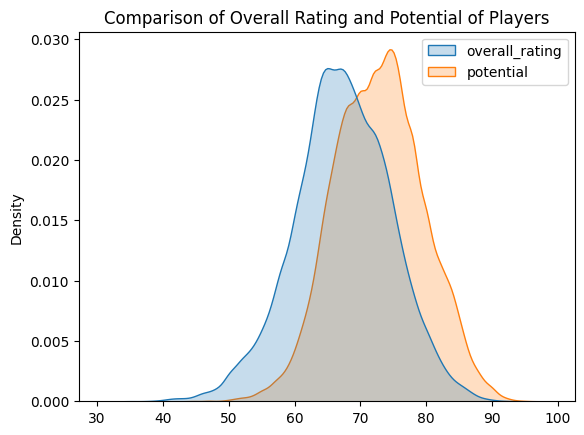

In [63]:
sns.kdeplot(data=df_player_attr[["overall_rating", "potential"]], fill=True,legend=True)
plt.title("Comparison of Overall Rating and Potential of Players")
plt.show()

Let's look at the relationship between Potential and Overall Rating

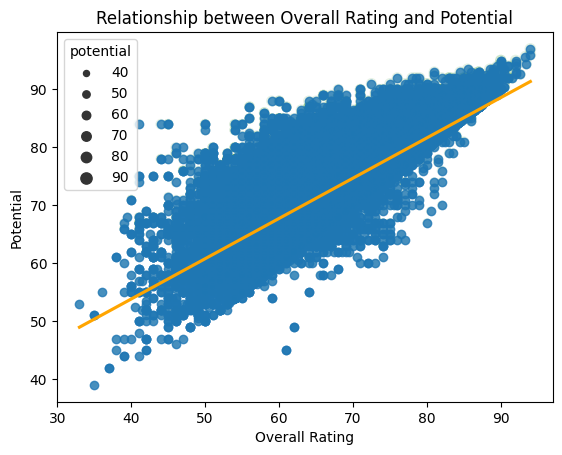

In [64]:
import seaborn as sns

sns.scatterplot(x="overall_rating", y="potential", size="potential", color='green', alpha=0.1, data=df_player_attr)
sns.regplot(x="overall_rating", y="potential", line_kws={"color": "orange"}, data=df_player_attr)
plt.xlabel("Overall Rating")
plt.ylabel("Potential")
plt.title("Relationship between Overall Rating and Potential")
plt.show()

We are going to calculate how many players have exceeded performance expectations.

In [65]:
underestimate_player = df_player_attr["overall_rating"] - df_player_attr["potential"]
underestimate_player = underestimate_player.astype(int)

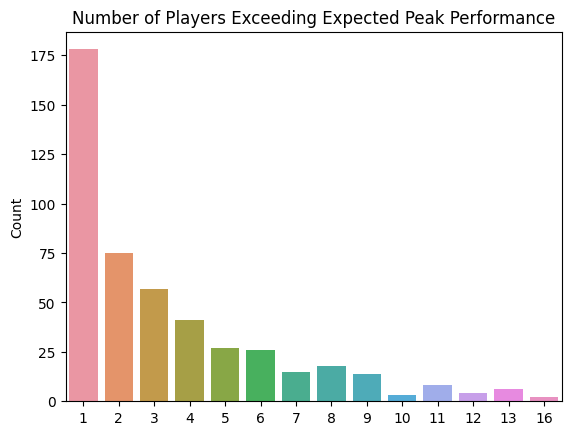

In [66]:
sns.countplot(x=underestimate_player[underestimate_player > 0])
plt.title("Number of Players Exceeding Expected Peak Performance")
plt.ylabel("Count")
plt.show()

Just over 400 players exceed their expected peak performance.

With the following figure, we will describe the predominant foot of the players. In general, we will see that 75% of the players use the right foot to play.

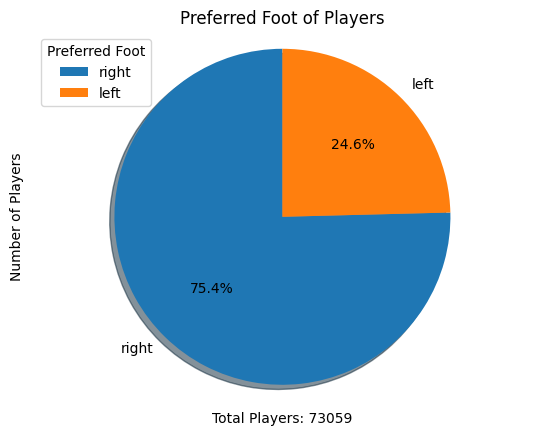

In [67]:
fig1, ax1 = plt.subplots()
ax1.pie(
    df_player_attr["preferred_foot"].value_counts(), 
    labels=df_player_attr["preferred_foot"].unique(), 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90
)
ax1.axis('equal')
total_players = df_player_attr["preferred_foot"].value_counts().sum()
plt.xlabel("Total Players: {}".format(total_players))
plt.ylabel("Number of Players")
plt.legend(df_player_attr["preferred_foot"].unique(), title="Preferred Foot")
plt.title("Preferred Foot of Players")
plt.show()

Now we will analyze the attributes of attacking_work_rate and defensive_work_rate, whose values ​​must be low, medium and high. However, this does not happen when detecting that other values ​​appear without apparent meaning. To solve this situation, we will eliminate those strange values ​​to later apply some technique for imputing missing values ​​if these attributes are finally used.

According to the results obtained, most of the players would have a medium work rate.

In [68]:
df_player_attr["defensive_work_rate"] = df_player_attr["defensive_work_rate"].astype(str)
df_player_attr["defensive_work_rate"].value_counts()

medium    51851
high       9721
low        7048
_0         1827
o          1094
ormal       249
1           196
2           147
3           139
5           117
7            98
6            94
0            84
9            79
ean          77
es           70
4            66
tocky        62
8            40
Name: defensive_work_rate, dtype: int64

We replace the strange values ​​with the value N/A.

In [69]:
df_player_attr["defensive_work_rate"].replace(inplace=True,to_replace=["_0","o","ormal","0","1","2","3","4","5","6","7","8","9","ean","es","tocky"],value=np.nan)

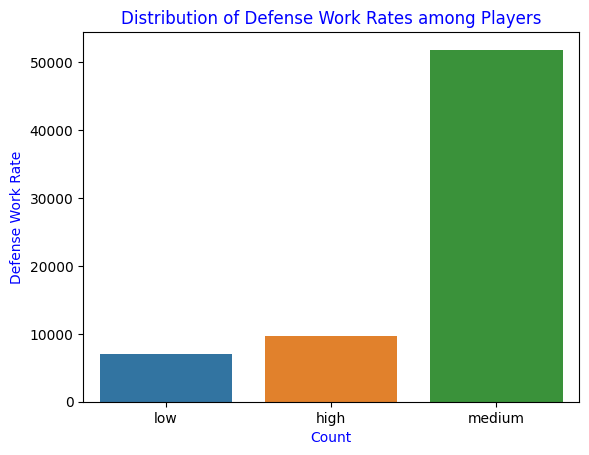

In [70]:
counts = df_player_attr["defensive_work_rate"].value_counts()
sorted_counts = counts.sort_values()
sns.countplot(x="defensive_work_rate", data=df_player_attr, order=sorted_counts.index)
plt.xlabel("Count", color="blue")
plt.ylabel("Defense Work Rate", color="blue")
plt.title("Distribution of Defense Work Rates among Players", color="blue")
plt.show()

In [71]:
df_player_attr["attacking_work_rate"] = df_player_attr["attacking_work_rate"].astype(str)
df_player_attr["attacking_work_rate"].value_counts()

medium    50394
high      14719
low        3570
None       2091
[]         1827
norm        249
le           77
y            70
stoc         62
Name: attacking_work_rate, dtype: int64

We replace the strange values ​​with the value N/A.

In [72]:
df_player_attr["attacking_work_rate"].replace(inplace=True,to_replace=["None","[]","norm","le","y","stoc"],value=np.nan)

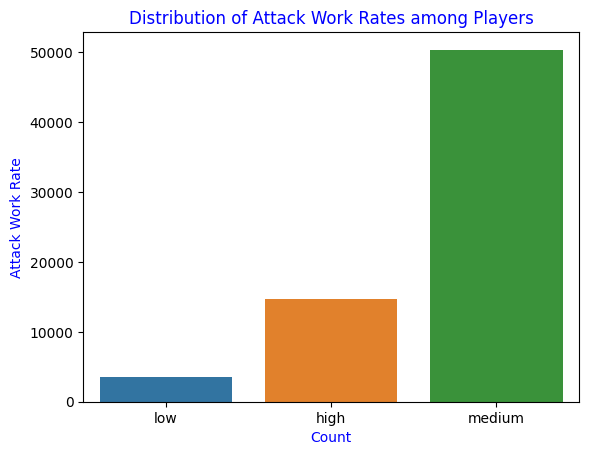

In [73]:
counts = df_player_attr["attacking_work_rate"].value_counts()
sorted_counts = counts.sort_values()
sns.countplot(x="attacking_work_rate", data=df_player_attr, order=sorted_counts.index)
plt.xlabel("Count", color="blue")
plt.ylabel("Attack Work Rate", color="blue")
plt.title("Distribution of Attack Work Rates among Players", color="blue")
plt.show()

Next, we are going to analyze the rest of the remaining characteristics by groups.

In [74]:
# Check the data type of the 'col' column
print(df_player_attr.columns.tolist())

['player_api_id', 'date', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'birthday', 'BMI', 'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']


In [75]:
draw_features1 = ['crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing']

draw_features2 = ['ball_control', 'acceleration',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength']

draw_features3 = ['long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'sliding_tackle','gk_diving']

draw_features4 = ['gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']

In this first group, we see that mainly all the variables describe a normal distribution, reaching its peak around a value of 60.

Of all the variables present, possibly the finishing field is the one with the most irregularities, since it has two peaks, at values ​​20 and 60 respectively. This is due to the fact that this parameter is more oriented to evaluate forwards than defenses.

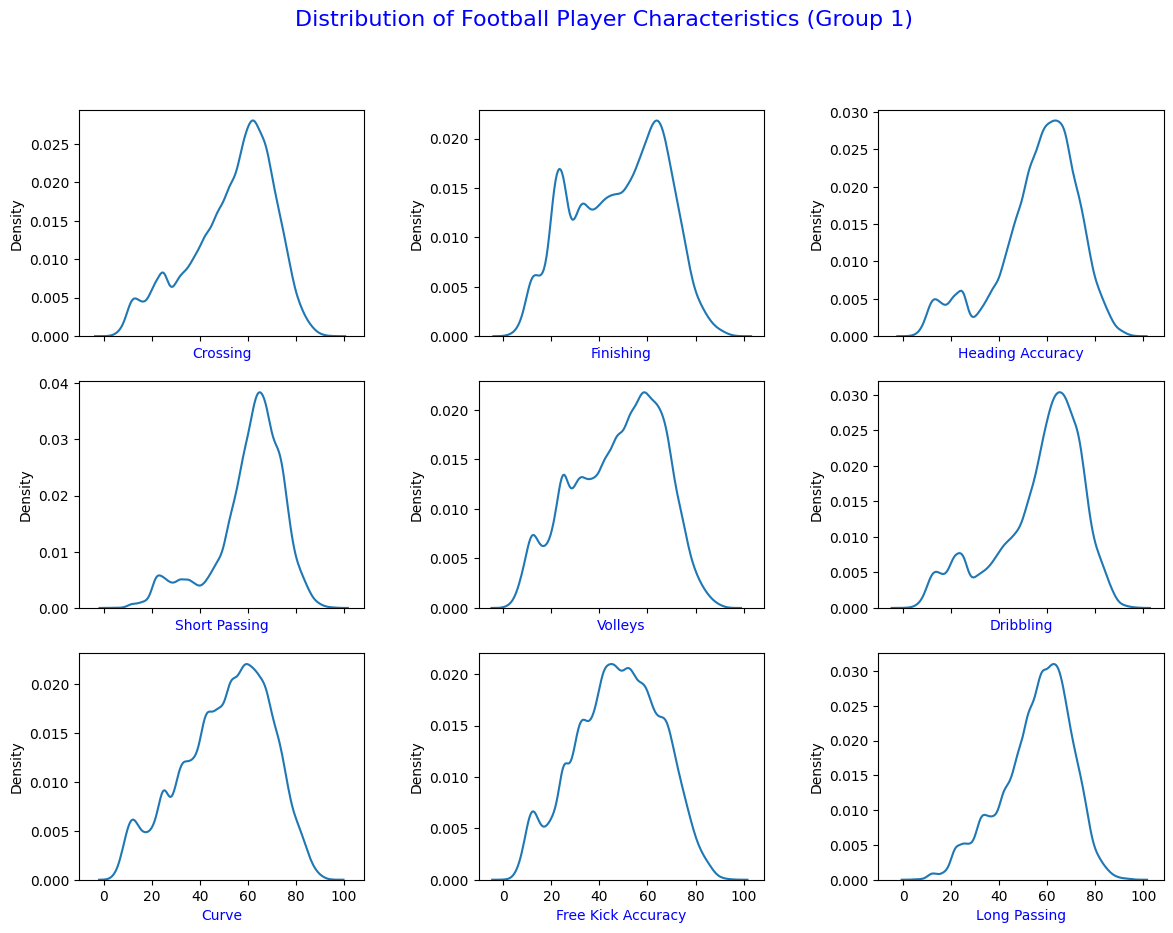

In [76]:
import string

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns

fig, axs = plt.subplots(a, b, figsize=(14,10), sharex=True, gridspec_kw={'wspace': 0.4})
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1)

for ax, feature in zip(axs.flat, draw_features1):
    ax.set_xlabel(string.capwords(feature.replace("_", " ")), color="blue")
    sns.kdeplot(data = df_player_attr, x=feature, ax=ax)

fig.suptitle("Distribution of Football Player Characteristics (Group 1)", fontsize=16, color="blue")
    
plt.show()

In the second group of attributes, something similar seems to happen. Most players get very positive scores between 60 and 80.

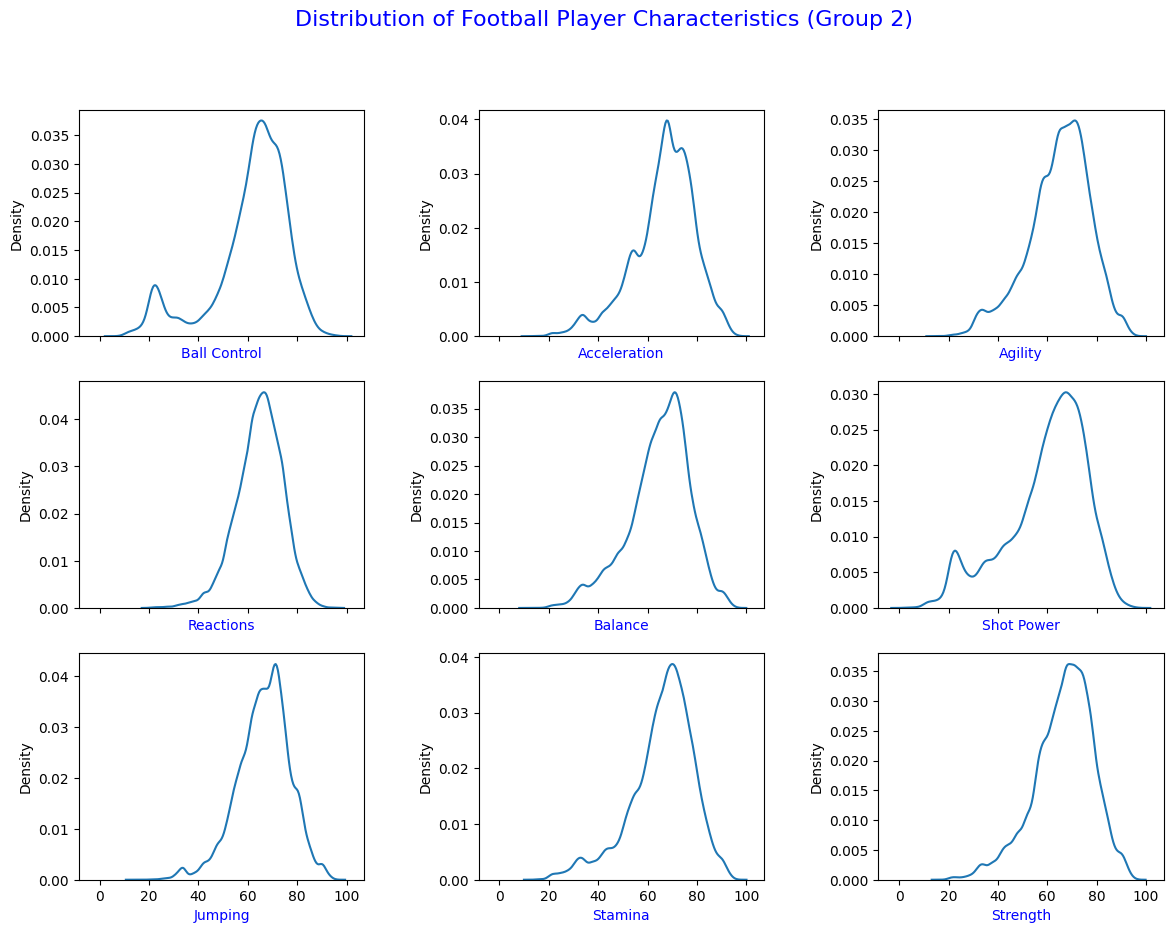

In [77]:
import string

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns

fig, axs = plt.subplots(a, b, figsize=(14,10), sharex=True, gridspec_kw={'wspace': 0.4})
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1)

for ax, feature in zip(axs.flat, draw_features2):
    ax.set_xlabel(string.capwords(feature.replace("_", " ")), color="blue")
    sns.kdeplot(data = df_player_attr, x=feature, ax=ax)

fig.suptitle("Distribution of Football Player Characteristics (Group 2)", fontsize=16, color="blue")
plt.show()

Similar to the previous graphs, most of the variables describe a normal distribution with a mean of 60. However, there are other attributes such as interceptions, marking, standing_tackle that present two well-defined peaks around the values ​​20 and 60. These cases usually indicate that these attributes mainly evaluate the abilities of a type of player such as forwards.

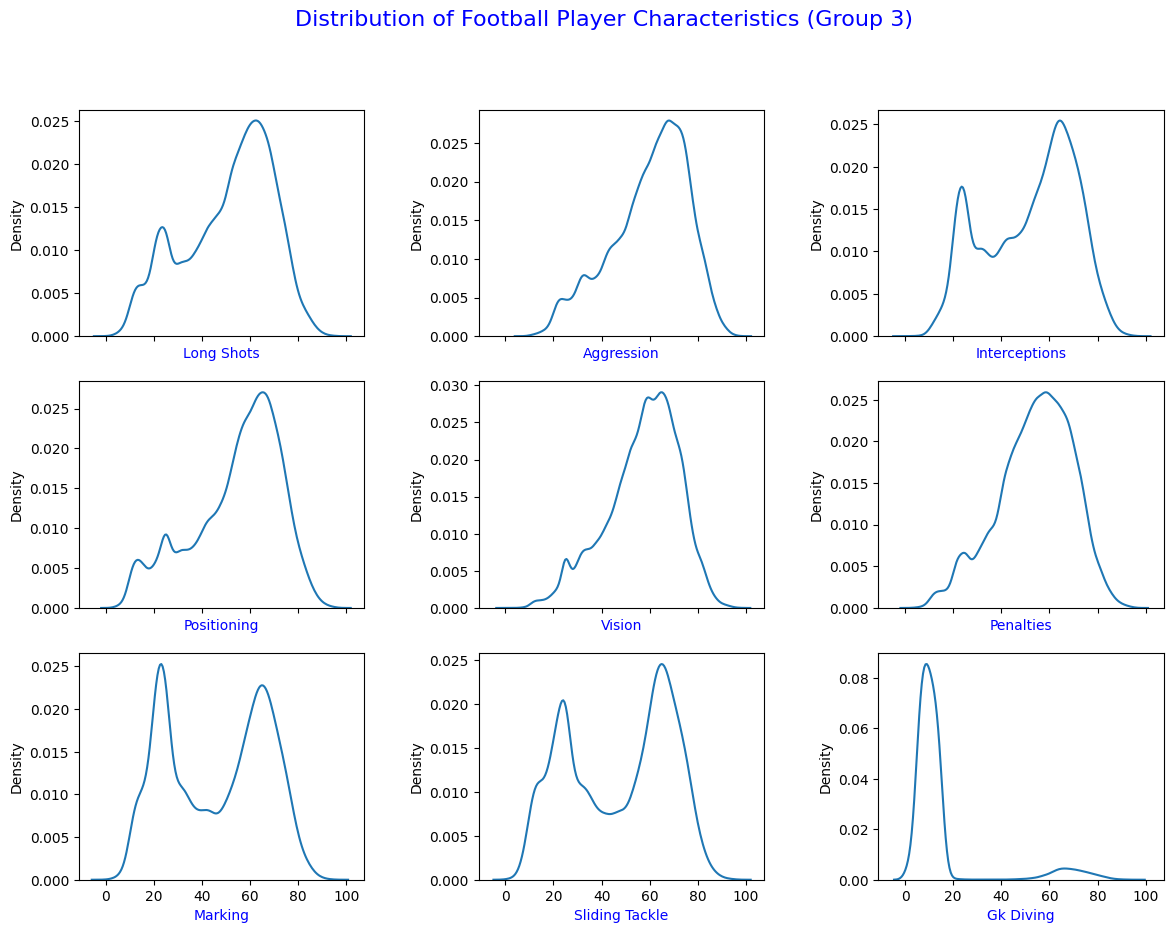

In [78]:
import string

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns

fig, axs = plt.subplots(a, b, figsize=(14,10), sharex=True, gridspec_kw={'wspace': 0.4})
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1)

for ax, feature in zip(axs.flat, draw_features3):
    ax.set_xlabel(string.capwords(feature.replace("_", " ")), color="blue")
    sns.kdeplot(data = df_player_attr, x=feature, ax=ax)

fig.suptitle("Distribution of Football Player Characteristics (Group 3)", fontsize=16, color="blue")
plt.show()

The last set of attributes to analyze has the form gk_xxxxx, which indicate or evaluate the performance of a player when playing the role of goalkeeper. In this case, all players have value of these attributes, whether or not they are goalkeepers. As we can see, the mean of the distribution is above the value 20. This is mainly due to the fact that the vast majority of players are not goalkeepers and have low performance as goalkeepers.

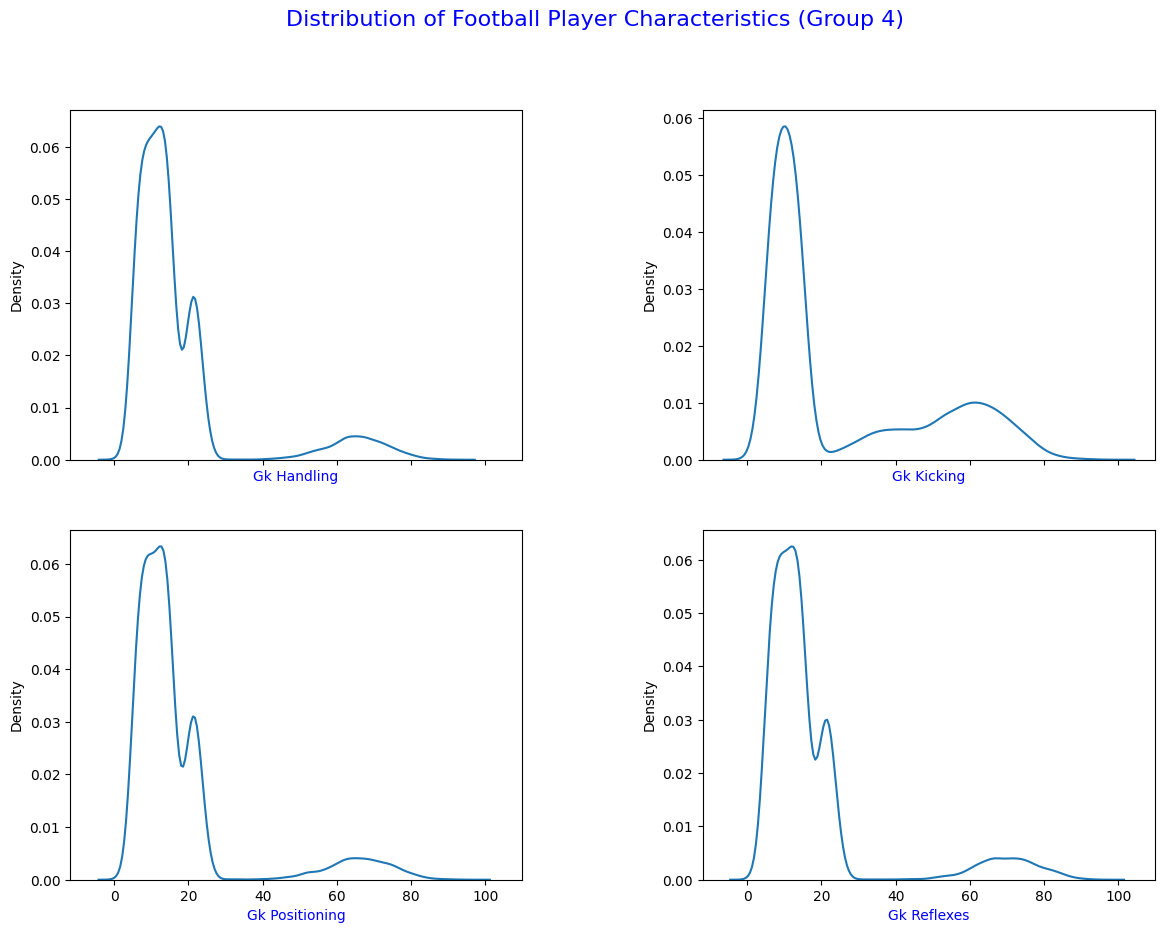

In [79]:
import string

#  Categorical Data
a = 2  # number of rows
b = 2  # number of columns

fig, axs = plt.subplots(a, b, figsize=(14,10), sharex=True, gridspec_kw={'wspace': 0.4})
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1)

for ax, feature in zip(axs.flat, draw_features4):
    ax.set_xlabel(string.capwords(feature.replace("_", " ")), color="blue")
    sns.kdeplot(data = df_player_attr, x=feature, ax=ax)

fig.suptitle("Distribution of Football Player Characteristics (Group 4)", fontsize=16, color="blue")
plt.show()

Next, we are going to find out if there are correlations between variables, which implies that they are redundant variables that do not provide extra information.

In [80]:
player_att_corrs = df_player_attr.corr(numeric_only=True)
player_att_corrs = player_att_corrs.mask(np.tril(np.ones(player_att_corrs.shape)).astype(bool))
player_att_corrs = player_att_corrs.stack().reset_index()

In [81]:
player_att_corrs[(player_att_corrs[0] >= 0.8) | (player_att_corrs[0] <= -0.8)].sort_values(by=0,ascending=False)

level_0          level_1         0
736      gk_handling   gk_positioning  0.971326
740   gk_positioning      gk_reflexes  0.971071
737      gk_handling      gk_reflexes  0.970859
713          marking  standing_tackle  0.951262
720  standing_tackle   sliding_tackle  0.945991
714          marking   sliding_tackle  0.929806
734        gk_diving      gk_reflexes  0.926814
733        gk_diving   gk_positioning  0.917147
731        gk_diving      gk_handling  0.916346
488     acceleration     sprint_speed  0.903734
366        dribbling     ball_control  0.890270
311    short_passing     ball_control  0.885714
247        finishing          volleys  0.848741
591       shot_power       long_shots  0.833440
349          volleys       long_shots  0.812342
221         crossing     ball_control  0.812334
262        finishing       long_shots  0.811674
363        dribbling            curve  0.805820
217         crossing        dribbling  0.805807
376        dribbling       long_shots  0.804951

Based on the following table of correlations, we could remove the following variables: sprint_speed, standing_tackle, sliding_tackle, gk_reflexes", gk_diving , gk_handling since they are closely related to the rest. However, we will leave this phase when we generate the final dataset.

In [82]:
df_player_attr.drop(columns=["sprint_speed","standing_tackle", "sliding_tackle", "gk_reflexes","gk_diving","gk_handling"],inplace=True)

## Country

This data set shows all the countries of the soccer teams that are included in this database, which in this case are 11.

In [83]:
df_country = football_db["Country"]
df_country.set_index('id', inplace=True) # We assign as index the value of the id column
df_country.head()

name
id            
1      Belgium
1729   England
4769    France
7809   Germany
10257    Italy

In [84]:
df_country.shape

(11, 1)

## League

This dataset is similar to the previous dataset but describing the leagues that exist for each country. In this particular case, there is a 1:1 relationship, that is, only information from one league per country is displayed.

In [85]:
df_league.set_index('id', inplace=True) # We assign as index the value of the id column
df_league

country_id                      name
id                                         
1               1    Belgium Jupiler League
1729         1729    England Premier League
4769         4769            France Ligue 1
7809         7809     Germany 1. Bundesliga
10257       10257             Italy Serie A
13274       13274    Netherlands Eredivisie
15722       15722        Poland Ekstraklasa
17642       17642  Portugal Liga ZON Sagres
19694       19694   Scotland Premier League
21518       21518           Spain LIGA BBVA
24558       24558  Switzerland Super League

Since it is a 1:1 relationship, we have decided to merge the league and country dataframes into one dataframe.

In [86]:
df_league_country = df_country.merge(df_league, left_index=True, right_index=True)

In [87]:
df_league_country.head()

name_x  country_id                  name_y
id                                                
1      Belgium           1  Belgium Jupiler League
1729   England        1729  England Premier League
4769    France        4769          France Ligue 1
7809   Germany        7809   Germany 1. Bundesliga
10257    Italy       10257           Italy Serie A

In [88]:
df_league_country.drop(['country_id'], axis=1, inplace=True)

We assign names to the columns

In [89]:
df_league_country.columns = ["Country", "League"]

In [90]:
df_league_country

Country                    League
id                                          
1          Belgium    Belgium Jupiler League
1729       England    England Premier League
4769        France            France Ligue 1
7809       Germany     Germany 1. Bundesliga
10257        Italy             Italy Serie A
13274  Netherlands    Netherlands Eredivisie
15722       Poland        Poland Ekstraklasa
17642     Portugal  Portugal Liga ZON Sagres
19694     Scotland   Scotland Premier League
21518        Spain           Spain LIGA BBVA
24558  Switzerland  Switzerland Super League

## Match

The next data frame to be analyzed contains information / statistics about the football matches that have been played.

In [91]:
df_match.head()

id  country_id     season  stage                 date  match_api_id  \
0   1           1  2008/2009      1  2008-08-17 00:00:00        492473   
1   2           1  2008/2009      1  2008-08-16 00:00:00        492474   
2   3           1  2008/2009      1  2008-08-16 00:00:00        492475   
3   4           1  2008/2009      1  2008-08-17 00:00:00        492476   
4   5           1  2008/2009      1  2008-08-16 00:00:00        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  ...  \
0              9987              9993               1               1  ...   
1             10000              9994               0               0  ...   
2              9984              8635               0               3  ...   
3              9991              9998               5               0  ...   
4              7947              9985               1               3  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 114 columns]

In [92]:
df_match[["id","season","country_id","stage"]].groupby(by=["season","country_id"]).count().describe()

id       stage
count   88.000000   88.000000
mean   295.215909  295.215909
std     77.388028   77.388028
min     12.000000   12.000000
25%    240.000000  240.000000
50%    306.000000  306.000000
75%    380.000000  380.000000
max    380.000000  380.000000

We get the size of the dataset: 25979 instances and 111 attributes.

In [93]:
df_match.shape

(25979, 114)

First, let's remove those useless attributes like the id field and set the match_api_id attribute as an index.

In [94]:
df_match.drop(columns=["id"], inplace=True)

In [95]:
df_match.set_index('match_api_id', inplace=True) # We assign as index the value of the id column

Next, we will analyze the number of missing values.

In [96]:
df_match.isnull().sum() * 100 / len(df_match)

country_id           0.000000
season               0.000000
stage                0.000000
date                 0.000000
home_team_api_id     0.000000
                      ...    
GBD                 45.486739
GBA                 45.486739
BSH                 45.490589
BSD                 45.490589
BSA                 45.490589
Length: 112, dtype: float64

With these missing values ​​data, we could eliminate the **PSH**, **PSD** and **PSA** variables because they have a very high percentage of missing values ​​(greater than 50%).

In [97]:
df_match.drop(columns=["PSH","PSD","PSA"],inplace=True)

We have observed that there are about 1800 instances that have all the **away_player_n**, **home_player_n**, **away_player_Xn**, and **home_player_Yn** attributes missing. Consequently, we are going to remove these instances because the absence of these attributes represents 66% of the instance and it would be very complex to try to impute those values.

In [98]:
for attribute in ["home_player_X", "away_player_X", "home_player_", "away_player_", "home_player_Y", "away_player_Y"]:
    for number in range(1,2):
        variable = str(attribute) + "" + str(number)
        null_match_instances = df_match[df_match[variable].isnull()].index
        df_match.drop(null_match_instances,inplace=True)
        df_match[variable] = df_match[variable].astype(int)

In [99]:
df_match.isnull().sum()

country_id              0
season                  0
stage                   0
date                    0
home_team_api_id        0
                    ...  
GBD                 10437
GBA                 10437
BSH                 10437
BSD                 10437
BSA                 10437
Length: 109, dtype: int64

In [100]:
df_match.shape

(23895, 109)

We additionally analyze the number of seasons and obtain that currently data is shown from 2008 to 2015. An interesting fact is that we have more data the more recent it is.

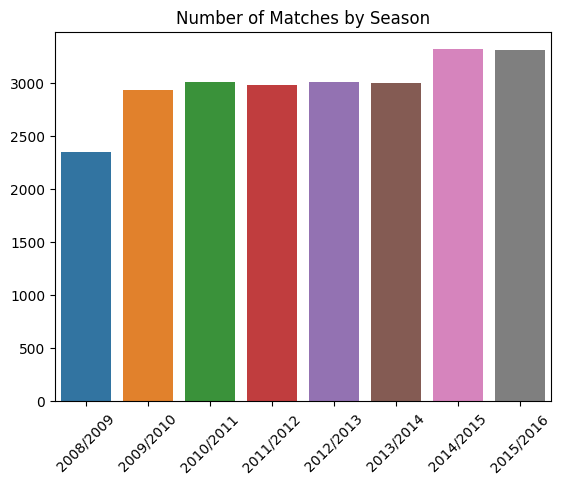

In [101]:
import pandas as pd
import seaborn as sns

sns.barplot(x=df_match["season"].value_counts().sort_index().index, y=df_match["season"].value_counts().sort_index().values)

plt.xticks(rotation=45)
plt.title("Number of Matches by Season")

plt.show()

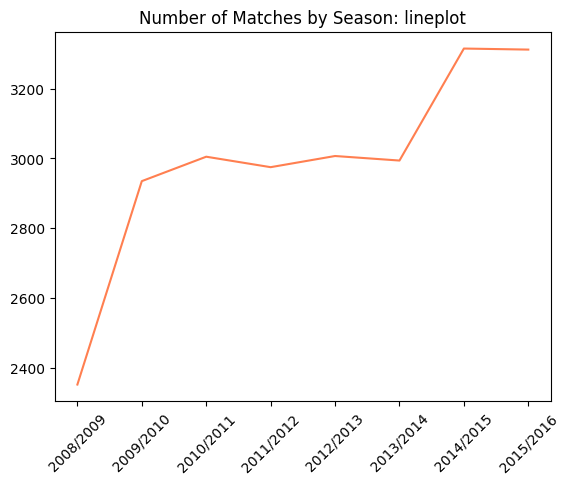

In [102]:
sns.lineplot(x=df_match["season"].value_counts().sort_index().index, y=df_match["season"].value_counts().sort_index().values, color="coral")

plt.xticks(rotation=45)
plt.title("Number of Matches by Season: lineplot")

plt.show()

Regarding the **season** attribute, we are going to extract only the first year to make it easier when making relationships with variables from other datasets.

In [103]:
df_match["season"]=  df_match["season"].apply(lambda x: x[:4])

Another relevant data is the proportion of parties that belong to each league. In this way, according to the extracted data, we see that the games played by the English, Italian, French and Spanish leagues predominate in the dataset.

In [104]:
df_match.head()

country_id season  stage                 date  home_team_api_id  \
match_api_id                                                                    
493016                 1   2008     24  2009-02-28 00:00:00              9996   
493017                 1   2008     24  2009-02-27 00:00:00              8203   
493018                 1   2008     24  2009-02-28 00:00:00              9986   
493020                 1   2008     24  2009-03-01 00:00:00              9994   
493021                 1   2008     24  2009-02-28 00:00:00              8342   

              away_team_api_id  home_team_goal  away_team_goal  \
match_api_id                                                     
493016                    8635               1               1   
493017                    9987               2               1   
493018                    9998               3               0   
493020                    9991               0               1   
493021                    9999               2               1   

              home_player_X1  home_player_X2  ...    SJA   VCH   VCD   VCA  \
match_api_id                                  ...                            
493016                     1             2.0  ...   1.62  5.00  3.40  1.60   
493017                     1             2.0  ...   2.30  2.65  3.25  2.35   
493018                     1             2.0  ...   4.10  1.90  3.25  3.75   
493020                     1             2.0  ...   2.50  2.80  3.25  2.30   
493021                     1             2.0  ...  10.00  1.25  5.00  9.50   

               GBH   GBD    GBA   BSH   BSD   BSA  
match_api_id                                       
493016        5.25  3.60   1.60  5.50  3.60  1.53  
493017        2.90  3.25   2.30  2.80  3.20  2.25  
493018        1.83  3.25   4.25  1.91  3.25  3.60  
493020        2.65  3.20   2.50  2.62  3.20  2.38  
493021        1.27  5.00  10.00  1.25  5.00  9.00  

[5 rows x 109 columns]

In [105]:
# how many unique countries are there?
print(df_match["country_id"].nunique())

# print a list of all the column names
print(list(df_match.columns))

# print the names of all the columns that exactly 11 unique values
print(list(df_match.columns[df_match.nunique() == 11]))

11
['country_id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_playe

In [106]:
# print head of the columns  'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11'
print(df_match[['country_id', 'home_team_api_id', 'away_team_api_id', 'home_player_X1', 'home_player_X2', 'goal', 'shoton']].head())

              country_id  home_team_api_id  away_team_api_id  home_player_X1  \
match_api_id                                                                   
493016                 1              9996              8635               1   
493017                 1              8203              9987               1   
493018                 1              9986              9998               1   
493020                 1              9994              9991               1   
493021                 1              8342              9999               1   

              home_player_X2  goal shoton  
match_api_id                               
493016                   2.0  None   None  
493017                   2.0  None   None  
493018                   2.0  None   None  
493020                   2.0  None   None  
493021                   2.0  None   None  


In [107]:
df_match.shape

(23895, 109)

In [108]:
df_league_country.head()

Country                  League
id                                    
1      Belgium  Belgium Jupiler League
1729   England  England Premier League
4769    France          France Ligue 1
7809   Germany   Germany 1. Bundesliga
10257    Italy           Italy Serie A

In [109]:
matches_by_country = df_match.merge(df_league_country, left_on="country_id", right_index=True)

In [110]:
matches_by_country.shape

(23895, 111)

In [111]:
matches_by_country.describe()

country_id         stage  home_team_api_id  away_team_api_id  \
count  23895.000000  23895.000000      23895.000000      23895.000000   
mean   11508.693534     18.548483      10174.722327      10185.284997   
std     7646.494973     10.488499      14589.462592      14616.994872   
min        1.000000      1.000000       1601.000000       1601.000000   
25%     4769.000000     10.000000       8528.000000       8528.000000   
50%    10257.000000     19.000000       9747.000000       9747.000000   
75%    19694.000000     27.000000       9925.000000       9925.000000   
max    24558.000000     38.000000     274581.000000     274581.000000   

       home_team_goal  away_team_goal  home_player_X1  home_player_X2  \
count    23895.000000    23895.000000    23895.000000    23895.000000   
mean         1.551873        1.170789        1.000042        2.074827   
std          1.302165        1.145701        0.006469        0.384267   
min          0.000000        0.000000        1.000000        1.000000   
25%          1.000000        0.000000        1.000000        2.000000   
50%          1.000000        1.000000        1.000000        2.000000   
75%          2.000000        2.000000        1.000000        2.000000   
max         10.000000        9.000000        2.000000        8.000000   

       home_player_X3  home_player_X4  ...           SJA           VCH  \
count    23895.000000    23895.000000  ...  16374.000000  21838.000000   
mean         4.061184        6.049466  ...      4.626793      2.677121   
std          0.386132        0.446967  ...      3.657199      1.939374   
min          1.000000        2.000000  ...      1.100000      1.030000   
25%          4.000000        6.000000  ...      2.500000      1.700000   
50%          4.000000        6.000000  ...      3.500000      2.150000   
75%          4.000000        6.000000  ...      5.250000      2.800000   
max          8.000000        8.000000  ...     41.000000     36.000000   

                VCD           VCA           GBH           GBD           GBA  \
count  21838.000000  21838.000000  13458.000000  13458.000000  13458.000000   
mean       3.908837      4.858098      2.505765      3.652297      4.358399   
std        1.260587      4.356664      1.505114      0.876215      3.029397   
min        1.620000      1.080000      1.050000      1.450000      1.120000   
25%        3.300000      2.550000      1.670000      3.200000      2.550000   
50%        3.500000      3.500000      2.100000      3.300000      3.400000   
75%        4.000000      5.400000      2.650000      3.750000      5.000000   
max       26.000000     67.000000     21.000000     11.000000     34.000000   

                BSH           BSD           BSA  
count  13458.000000  13458.000000  13458.000000  
mean       2.505616      3.665525      4.412748  
std        1.523669      0.876572      3.210983  
min        1.040000      1.330000      1.120000  
25%        1.670000      3.250000      2.500000  
50%        2.100000      3.400000      3.400000  
75%        2.620000      3.750000      5.000000  
max       17.000000     13.000000     34.000000  

[8 rows x 99 columns]

In [112]:
matches_by_country.head()

country_id season  stage                 date  home_team_api_id  \
match_api_id                                                                    
493016                 1   2008     24  2009-02-28 00:00:00              9996   
493017                 1   2008     24  2009-02-27 00:00:00              8203   
493018                 1   2008     24  2009-02-28 00:00:00              9986   
493020                 1   2008     24  2009-03-01 00:00:00              9994   
493021                 1   2008     24  2009-02-28 00:00:00              8342   

              away_team_api_id  home_team_goal  away_team_goal  \
match_api_id                                                     
493016                    8635               1               1   
493017                    9987               2               1   
493018                    9998               3               0   
493020                    9991               0               1   
493021                    9999               2               1   

              home_player_X1  home_player_X2  ...   VCD   VCA   GBH   GBD  \
match_api_id                                  ...                           
493016                     1             2.0  ...  3.40  1.60  5.25  3.60   
493017                     1             2.0  ...  3.25  2.35  2.90  3.25   
493018                     1             2.0  ...  3.25  3.75  1.83  3.25   
493020                     1             2.0  ...  3.25  2.30  2.65  3.20   
493021                     1             2.0  ...  5.00  9.50  1.27  5.00   

                GBA   BSH   BSD   BSA  Country                  League  
match_api_id                                                            
493016         1.60  5.50  3.60  1.53  Belgium  Belgium Jupiler League  
493017         2.30  2.80  3.20  2.25  Belgium  Belgium Jupiler League  
493018         4.25  1.91  3.25  3.60  Belgium  Belgium Jupiler League  
493020         2.50  2.62  3.20  2.38  Belgium  Belgium Jupiler League  
493021        10.00  1.25  5.00  9.00  Belgium  Belgium Jupiler League  

[5 rows x 111 columns]

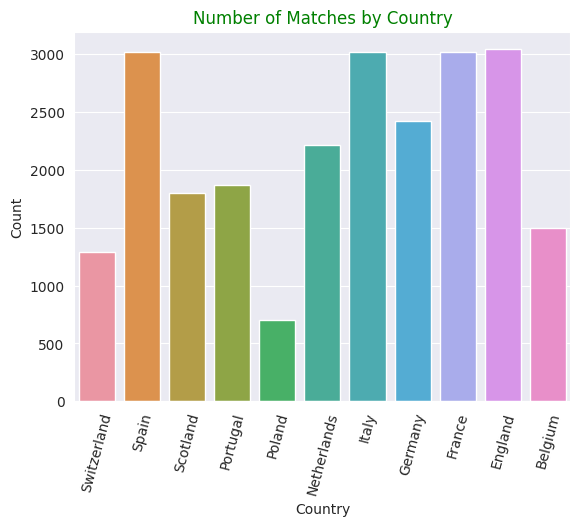

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort the dataframe by the "Country" column in descending order by count
matches_by_country_sorted = matches_by_country.sort_values(by="Country", ascending=False)

# Make the bar plot
sns.set_style("darkgrid")
plot = sns.countplot(x="Country", data=matches_by_country_sorted)

# Rotate the plot by 90 degrees
plt.xticks(rotation=75)

# Set the y-axis label to "Count"
plot.set_ylabel("Count")

# Add the title to the plot
plot.set_title("Number of Matches by Country", color='green', y=1)

# Make the plot interactive
plt.show()

## Which leagues are in which countries?

In [114]:
league_and_country = pd.merge(df_league, df_country, on='id')
league_and_country.rename(columns={'name_x': 'League', 'name_y': 'Country'}, inplace=True)
league_and_country.drop(columns=['country_id'], inplace=True)
league_and_country

League      Country
id                                          
1        Belgium Jupiler League      Belgium
1729     England Premier League      England
4769             France Ligue 1       France
7809      Germany 1. Bundesliga      Germany
10257             Italy Serie A        Italy
13274    Netherlands Eredivisie  Netherlands
15722        Poland Ekstraklasa       Poland
17642  Portugal Liga ZON Sagres     Portugal
19694   Scotland Premier League     Scotland
21518           Spain LIGA BBVA        Spain
24558  Switzerland Super League  Switzerland

## Which leagues score the most/fewest goals?

In [115]:
league_goals = matches_by_country[['League', 'home_team_goal', 'away_team_goal']]
league_goals.head()

League  home_team_goal  away_team_goal
match_api_id                                                        
493016        Belgium Jupiler League               1               1
493017        Belgium Jupiler League               2               1
493018        Belgium Jupiler League               3               0
493020        Belgium Jupiler League               0               1
493021        Belgium Jupiler League               2               1

In [116]:
league_goals = league_goals.assign(total_goals_in_match = league_goals['home_team_goal'] + league_goals['away_team_goal'])

In [117]:
league_goals.head()

League  home_team_goal  away_team_goal  \
match_api_id                                                           
493016        Belgium Jupiler League               1               1   
493017        Belgium Jupiler League               2               1   
493018        Belgium Jupiler League               3               0   
493020        Belgium Jupiler League               0               1   
493021        Belgium Jupiler League               2               1   

              total_goals_in_match  
match_api_id                        
493016                           2  
493017                           3  
493018                           3  
493020                           1  
493021                           3

In [118]:
league_goals = league_goals.drop(['home_team_goal', 'away_team_goal'], axis=1)
league_goals.head()

League  total_goals_in_match
match_api_id                                              
493016        Belgium Jupiler League                     2
493017        Belgium Jupiler League                     3
493018        Belgium Jupiler League                     3
493020        Belgium Jupiler League                     1
493021        Belgium Jupiler League                     3

In [119]:
league_totals = league_goals.groupby('League')['total_goals_in_match'].sum()
league_totals

League
Belgium Jupiler League      4187
England Premier League      8240
France Ligue 1              7378
Germany 1. Bundesliga       7027
Italy Serie A               7895
Netherlands Eredivisie      6877
Poland Ekstraklasa          1844
Portugal Liga ZON Sagres    4761
Scotland Premier League     4718
Spain LIGA BBVA             8341
Switzerland Super League    3790
Name: total_goals_in_match, dtype: int64

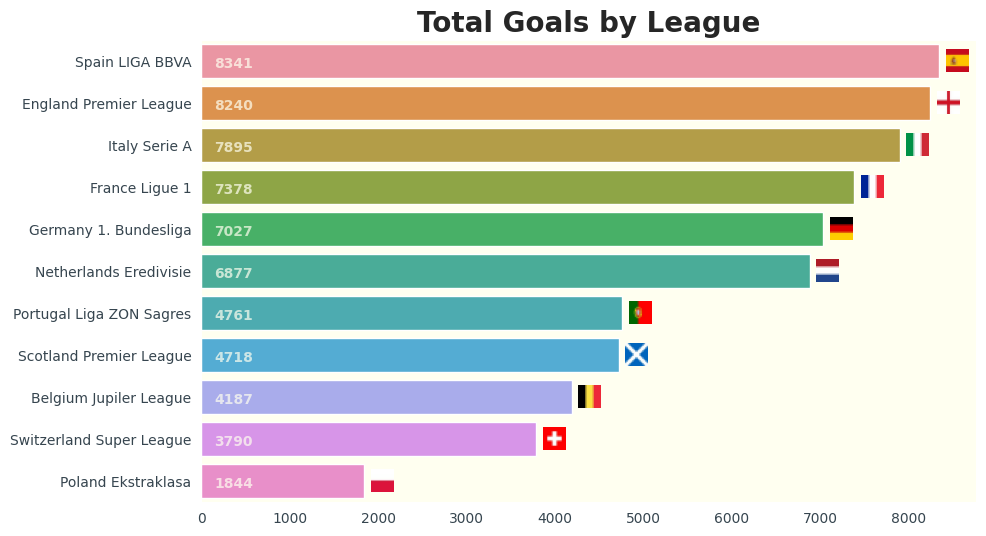

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Sort the league_totals Series in descending order
league_totals_sorted = league_totals.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Create the horizontal bar plot
ax = sns.barplot(x=league_totals_sorted.values, y=league_totals_sorted.index, orient='h') # palette='colorblind' if needed

# grid invisible and background color of plot ivory
ax.grid(False)
ax.set_facecolor('ivory')

# Set the color of the x-tick labels and y-tick labels to light grey
ax.tick_params(axis='both', labelcolor='#36454F')

# Add x-tick labels above the bars
for i, v in enumerate(league_totals_sorted.values):
    ax.text(150, i + 0.15, str(v), color='ivory', fontweight='bold', alpha=0.7)

# Add a title and axis labels
plt.title('Total Goals by League', fontweight='bold', fontsize=20)
plt.ylabel('')

# Add the flag images and total count numbers to the plot
for i, league in enumerate(league_totals_sorted.index):
    first_word = league.lower().split()[0]
    image_path = f'./flags/{first_word}.png'
    image = plt.imread(image_path)
    imagebox = OffsetImage(image, zoom=1)
    ab = AnnotationBbox(imagebox, (league_totals_sorted.values[i] + 200, i), frameon=False)
    plt.gca().add_artist(ab)

# Show the plot
plt.show()

#### Which leagues score the most/fewest goals?

- Spain LIGA BBVA scored the highest number of goals, that is 8341 goals.
- Poland Ekstraklasa scored the lowest number of goals, that is 1844 goals.

### Who are the top scorers in each team and league?

To answer this question, we need to figure out how and where can we merge the player table so that identifier of player can be revealed. We do this by automated search.

In [122]:
# drop the columns that are not needed for the next steps
df_match_light = df_match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], axis=1)

In [123]:
df_match_light.head()

country_id season  stage                 date  home_team_api_id  \
match_api_id                                                                    
493016                 1   2008     24  2009-02-28 00:00:00              9996   
493017                 1   2008     24  2009-02-27 00:00:00              8203   
493018                 1   2008     24  2009-02-28 00:00:00              9986   
493020                 1   2008     24  2009-03-01 00:00:00              9994   
493021                 1   2008     24  2009-02-28 00:00:00              8342   

              away_team_api_id  home_team_goal  away_team_goal  goal  
match_api_id                                                          
493016                    8635               1               1  None  
493017                    9987               2               1  None  
493018                    9998               3               0  None  
493020                    9991               0               1  None  
493021                    9999               2               1  None

In [124]:
# select the rows where goal is not None
df_filtered = df_match_light[df_match_light['goal'].notnull()]

# print the first five values from the goal column
print(df_filtered['goal'].head(5))

match_api_id
489042                                                                                                                                                                                                                            <goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>
489043                                                                       

## This seems to be xml data. We extract it on a leg and a prayer, as xml is very strict format.

In [125]:
# select the rows where goal is not None
df_match_light = df_match_light[pd.notnull(df_match_light['goal'])]

In [126]:
import lxml.etree as ET

def extract_xml(row,col_name,xml_key,away_home):
    count = 0
    
    element = row[col_name]
    team_id = row[away_home + "_team_api_id"]
    
    if type(element) == int:
        return element
    
    elif element != None:
       # print(row,element)
        tree = ElementTree(fromstring(element))
        root = tree.getroot()
        
        for child in root.iter(xml_key):
            
            if str(team_id) == child.text:
                count +=1
        return count
    else:
        return np.nan

### Shots taken on goal by Home-team vs Away Team

The **shoton** attribute contains information in xml format about the shots on goal taken in the match: shot time, player involved and beneficiary team.

In [127]:
df_match["shoton_away"] = df_match.apply(lambda x : extract_xml(x,"shoton","team","away"), axis = 1)
df_match["shoton_home"] = df_match.apply(lambda x : extract_xml(x,"shoton","team","home"), axis = 1)

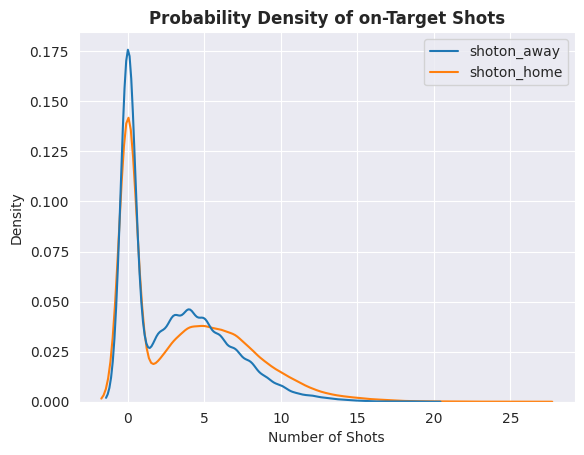

In [128]:
import matplotlib.pyplot as plt

sns.kdeplot(data=df_match[["shoton_away", "shoton_home"]], fill=False,legend=True)
plt.title("Probability Density of on-Target Shots", fontweight='bold')
plt.xlabel("Number of Shots")
plt.show()

In [129]:
df_match['homewin'] = df_match.apply(lambda x: 1 if x['home_team_goal'] > x['away_team_goal'] else 0 if x['home_team_goal'] == x['away_team_goal'] else -1, axis=1)

From the graph below: it seems that home teams tend to take more shots on goal than visiting teams.

The **shotoff** attribute contains information in xml format about the off-target shots taken in the match: time of the shot, player involved and beneficiary team.

In [130]:
df_match["shotoff_away"] = np.nan
df_match["shotoff_home"] = np.nan

In [131]:
df_match["shotoff_away"] = df_match.apply(lambda x : extract_xml(x,"shotoff","team","away"), axis = 1)
df_match["shotoff_home"] = df_match.apply(lambda x : extract_xml(x,"shotoff","team","home"), axis = 1)

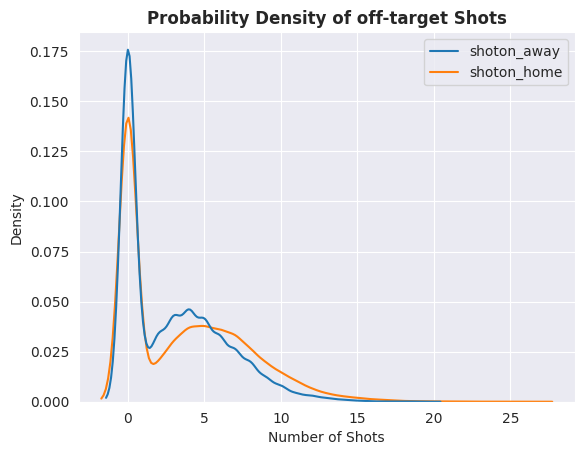

In [132]:
sns.kdeplot(data=df_match[["shoton_away", "shoton_home"]], fill=False,legend=True)
plt.title("Probability Density of off-target Shots", fontweight='bold')
plt.xlabel("Number of Shots")
plt.show()

In [133]:
shoton_away_total = df_match["shoton_away"].sum()
shoton_home_total = df_match["shoton_home"].sum()
print("Total number of shots on-target by away team:", shoton_away_total)
print("Total number of shots on-target by home team:", shoton_home_total)

Total number of shots on-target by away team: 41358.0
Total number of shots on-target by home team: 52134.0


As in the previous view, off-target shots tend to be more frequent in local teams. This could mean that these teams have more opportunities to take shots towards the opponent's goal, even if they are not ultimately considered a goal.

The **foulcommit** attribute contains information in xml format about the fouls committed in the match: minute of the foul, player involved and beneficiary team.

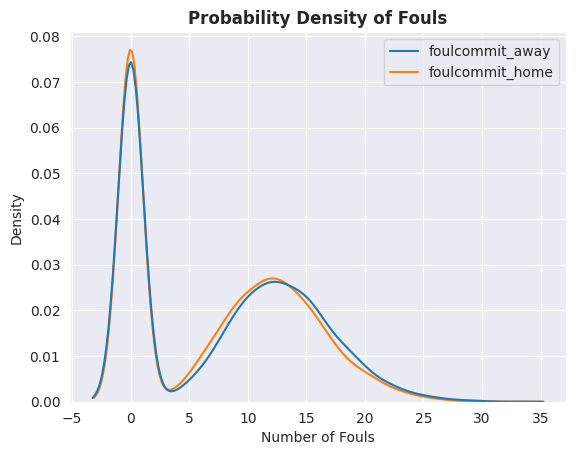

In [134]:
df_match["foulcommit_home"] = np.nan
df_match["foulcommit_away"] = np.nan
df_match["foulcommit_away"] = df_match.apply(lambda x : extract_xml(x,"foulcommit","team","away"), axis = 1)
df_match["foulcommit_home"] = df_match.apply(lambda x : extract_xml(x,"foulcommit","team","home"), axis = 1)
sns.kdeplot(data=df_match[["foulcommit_away", "foulcommit_home"]], fill=False,legend=True)
plt.title("Probability Density of Fouls", fontweight='bold')
plt.xlabel("Number of Fouls")
plt.show()

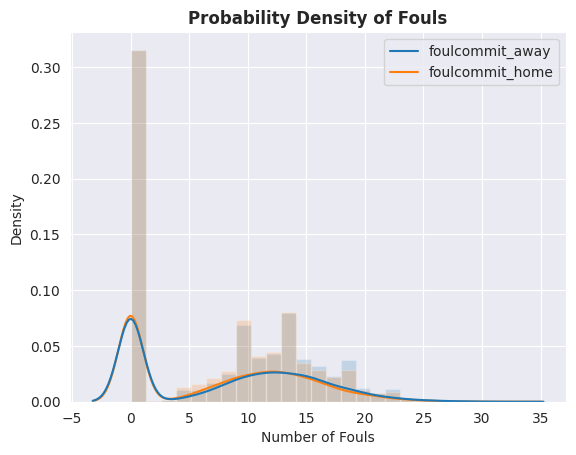

In [135]:
plt.hist(df_match["foulcommit_away"], bins=25, density=True, alpha=0.2)
plt.hist(df_match["foulcommit_home"], bins=25, density=True, alpha=0.2)
sns.kdeplot(data=df_match[["foulcommit_away", "foulcommit_home"]], fill=False, legend=True)
plt.title("Probability Density of Fouls", fontweight='bold')
plt.xlabel("Number of Fouls")
plt.show()

In [136]:
foulcommit_away_total = df_match["foulcommit_away"].sum()
foulcommit_home_total = df_match["foulcommit_home"].sum()
print("Total number of fouls committed by away team:", foulcommit_away_total)
print("Total number of fouls committed by home team:", foulcommit_home_total)

Total number of fouls committed by away team: 111495.0
Total number of fouls committed by home team: 106763.0


Regarding the fouls committed, we see that both teams present a practically identical trend.

The **card** attribute contains information in xml format about the cards that have been assigned during the match: minute of the card, player involved and affected team.

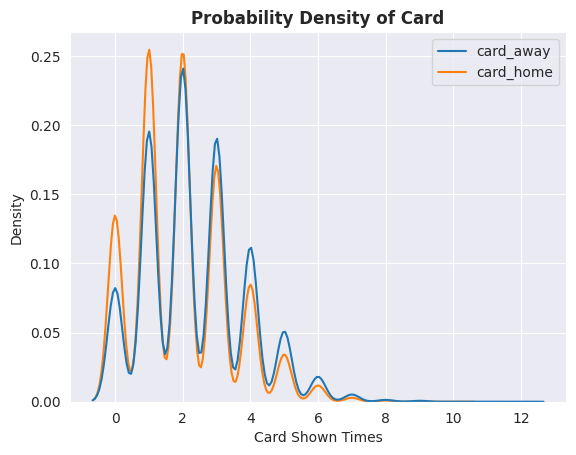

In [137]:
df_match["card_home"] = np.nan
df_match["card_away"] = np.nan
df_match["card_home"] = df_match.apply(lambda x : extract_xml(x,"card","team","home"), axis = 1)
df_match["card_away"] = df_match.apply(lambda x : extract_xml(x,"card","team","away"), axis = 1)
sns.kdeplot(data=df_match[["card_away", "card_home"]], fill=False,legend=True)
plt.title("Probability Density of Card", fontweight='bold')
plt.xlabel("Card Shown Times")
plt.show()

Regarding the number of cards, we could conclude that the local teams are sanctioned slightly less than the visiting teams. We also see that for the most part the number of cards distributed per game tends to range between 0 and 2.

The **cross** attribute contains information in xml format about the passes made in the match: minute of the pass, player involved and team.

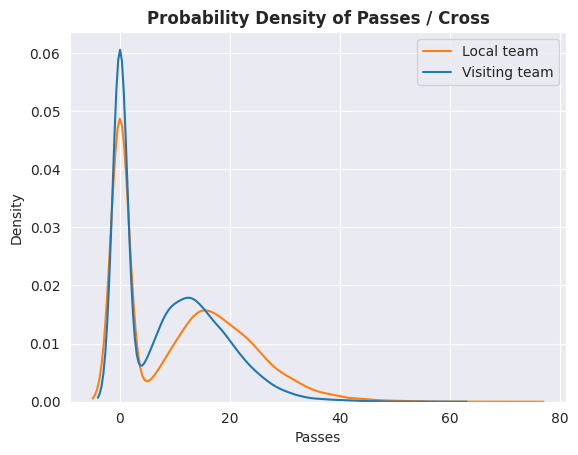

Total number of passes / cross by away team: 124574.0
Total number of passes / cross by home team: 159357.0


In [138]:
df_match["cross_home"] = np.nan
df_match["cross_away"] = np.nan
df_match["cross_home"] = df_match.apply(lambda x : extract_xml(x,"cross","team","home"), axis = 1)
df_match["cross_away"] = df_match.apply(lambda x : extract_xml(x,"cross","team","away"), axis = 1)
sns.kdeplot(data=df_match[["cross_away", "cross_home"]], fill=False,legend=True)
plt.title("Probability Density of Passes / Cross", fontweight='bold')
plt.legend(labels=["Local team","Visiting team"])
plt.xlabel("Passes")
plt.show()
cross_away_total = df_match["cross_away"].sum()
cross_home_total = df_match["cross_home"].sum()
print("Total number of passes / cross by away team:", cross_away_total)
print("Total number of passes / cross by home team:", cross_home_total)

In the case of passes, we see that local teams usually make more passes, standing around 20.

The **possession** attribute contains information in xml format about possession in the match.

In [139]:
def extract_possession_xml(row,col_name,xml_key):
    count = 0
    sum_pos = 0
    
    element = row[col_name]
    
    if type(element) == int:
        return element
    
    elif element != None:
       # print(row,element)
        tree = ElementTree(fromstring(element))
        root = tree.getroot()
        
        for child in root.iter(xml_key):
            count+=1
            sum_pos += int(child.text)
        
        if count == 0:
            return np.nan
        else:
            return sum_pos/count
    else:
        return np.nan

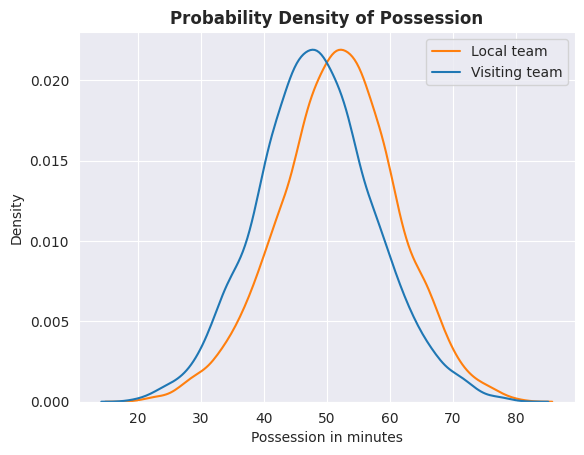

Total minutes of possession by away team: 404844.0407761829
Total minutes of possession by home team: 435055.9592238171


In [140]:
df_match["possession_home"] = np.nan
df_match["possession_away"] = np.nan
df_match["possession_home"] = df_match.apply(lambda x : extract_possession_xml(x,"possession","homepos"), axis = 1)
df_match["possession_away"] = df_match.apply(lambda x : extract_possession_xml(x,"possession","awaypos"), axis = 1)

sns.kdeplot(data=df_match[["possession_away", "possession_home"]], fill=False,legend=True)
plt.title("Probability Density of Possession", fontweight='bold')
plt.xlabel("Possession in minutes")
plt.legend(labels=["Local team","Visiting team"])
plt.show()

print("Total minutes of possession by away team:", df_match["possession_away"].sum())
print("Total minutes of possession by home team:", df_match["possession_home"].sum())

In the case of possession, it seems that both opponents are on average around 50%, although there is a certain tendency for local teams to have a higher percentage of possession.

### Analyze the betting odds of winning and losing by various betting groups.

The next columns to analyze would be the following, which represent the **odds** given by each bookmaker.
- B365X = Bet365 odds
- BWX = Bet&Win odds
- IWX = Interwetten odds
- LBX = Ladbrokes odds
- WHX = William Hill odds
- BSX = Blue Square odds
- GBX = Gamebookers odds
- PSX = Pinnacle odds
- SJX = Stan James odds
- VCX = VC Bet odds

In [141]:
odds=pd.DataFrame([])

for betting_house in ["B365", "BW", "IW", "LB", "WH", "BS", "GB", "SJ", "VC"]:
    for outcome in ["H", "D", "A"]:
        cad = betting_house + outcome
        
        odds[cad] = 1 / df_match[cad]
        
# "cad": It is a variable that represents a combination of betting houses and teams or outcomes. The variable is created by concatenating the current value of "betting_house" with the current value of "outcome" in each iteration of the nested for loop.

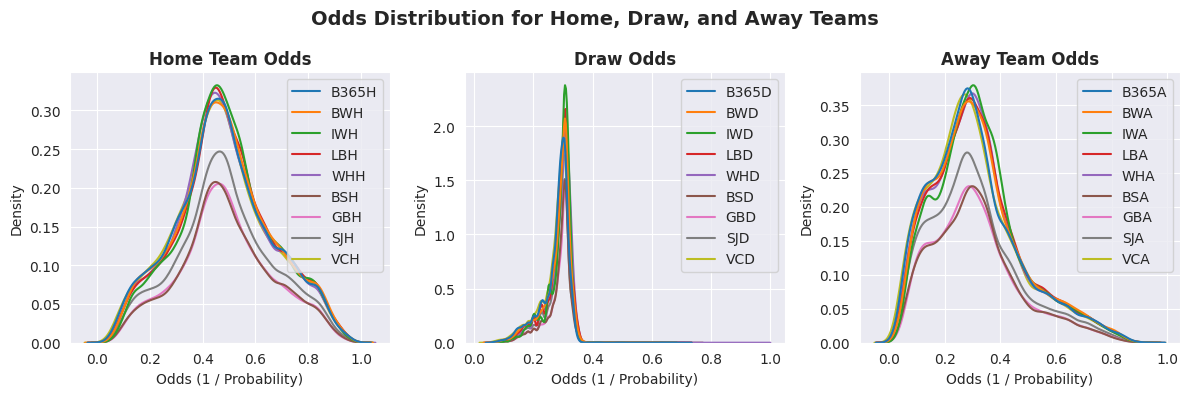

In [142]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Add the super-title for the entire figure
fig.suptitle("Odds Distribution for Home, Draw, and Away Teams", fontweight="bold", fontsize=14)

# First subplot
sns.kdeplot(
    data=odds[[ cad for cad in ["B365H", "BWH", "IWH", "LBH", "WHH", "BSH", "GBH", "SJH", "VCH"] ]], 
    fill=False,
    legend=True,
    ax=ax1
)

ax1.set_title("Home Team Odds", fontweight="bold")
ax1.set_xlabel("Odds (1 / Probability)")

# Second subplot
sns.kdeplot(
    data=odds[[ cad for cad in ["B365D", "BWD", "IWD", "LBD", "WHD", "BSD", "GBD", "SJD", "VCD"] ]], 
    fill=False,
    legend=True,
    ax=ax2
)
ax2.set_title("Draw Odds", fontweight="bold")
ax2.set_xlabel("Odds (1 / Probability)")

# Third subplot
sns.kdeplot(
    data=odds[[ cad for cad in ["B365A", "BWA", "IWA", "LBA", "WHA", "BSA", "GBA", "SJA", "VCA"] ]], 
    fill=False,
    legend=True,
    ax=ax3
)
ax3.set_title("Away Team Odds", fontweight="bold")
ax3.set_xlabel("Odds (1 / Probability)")

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the figure
plt.show()

It appears that the different betting houses have odds very near to each other, and these odds are slightly skewed towards home team winning.

**we can assume that the betting groups expect results to favour the home-team overall**

Now, let's explore the following data:

- home_team_goal: Home team goals
- away_team_goal: Away team goals
- home_player_Xx: Position of player x on the X axis
- home_player_Yy: Player y position on the Y axis
- home_player_n: Identifier of player n

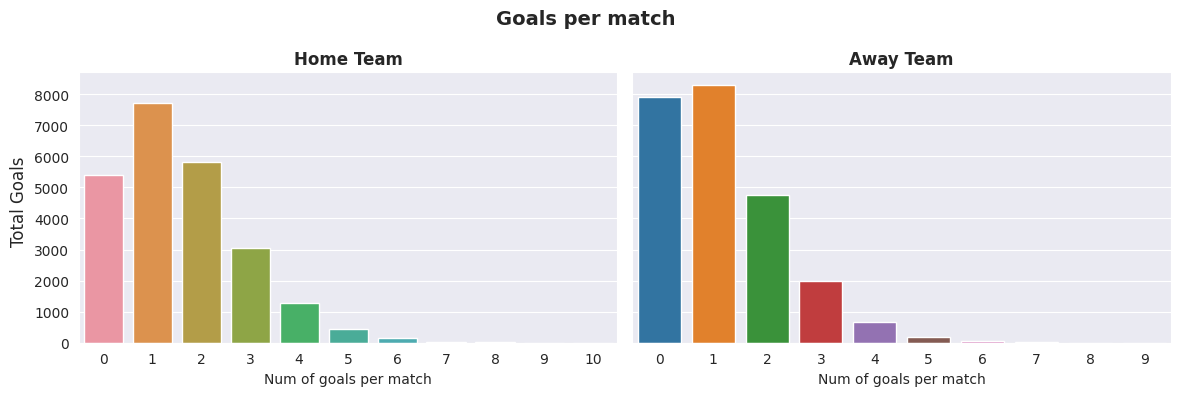

In [143]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.supylabel("Total Goals")
fig.suptitle("Goals per match", fontweight="bold", fontsize=14)
sns.countplot(x="home_team_goal", data=df_match, ax = ax1)
ax1.set_title("Home Team", fontweight="bold")
ax1.set_xlabel("Num of goals per match")
ax1.set_ylabel("")

sns.countplot(x="away_team_goal", data=df_match, ax=ax2)
ax2.set_title("Away Team", fontweight="bold")
ax2.set_xlabel("Num of goals per match")
ax2.set_ylabel("")

# Adjust the spacing between the subplots
plt.tight_layout()
plt.show()

The goals of the local team are usually more favorable than those of the guest team. In this case, a local team is more likely to score goals, at least 1 goal while guest teams have a high probability of not scoring any goal.

**the data indicates that the betting odds placed by the betting groups are in line with the actual real-world results**

In [144]:
# make the values of column goal numberic and equal to the sum of home_team_goal and away_team_goal
df_match["goal"] = df_match["home_team_goal"] + df_match["away_team_goal"]
goals_season = df_match[["season","goal","away_team_goal","home_team_goal"]].groupby(by="season").sum(numeric_only="False")
print(df_match["goal"].head(5), "\n-----------------\n")
goals_season.head(5)

match_api_id
493016    2
493017    3
493018    3
493020    1
493021    3
Name: goal, dtype: int64 
-----------------



goal  away_team_goal  home_team_goal
season                                      
2008    6119            2600            3519
2009    7940            3357            4583
2010    8126            3471            4655
2011    8198            3446            4752
2012    8409            3700            4709

### We can represent the difference even by time-scale comparison of goals between the home-team total goals vs away-team total goals

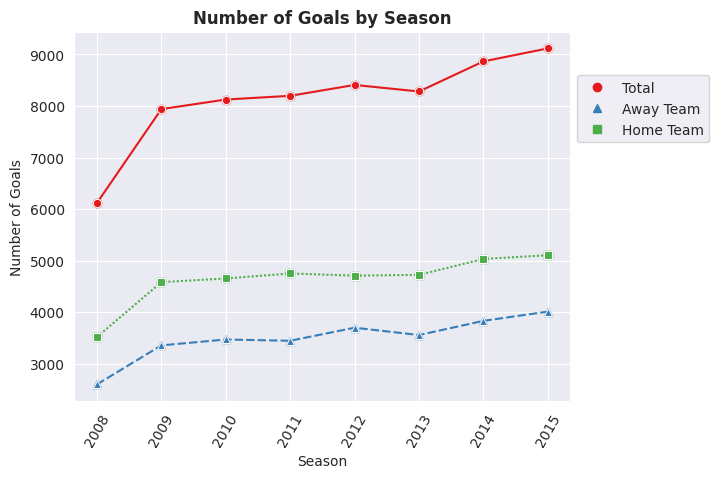

In [145]:
sns.set_palette("Set1")
goals_season.iloc[:,0].plot(style="o")
goals_season.iloc[:,1].plot(style="^")
goals_season.iloc[:,2].plot(style="s")
sns.lineplot(data=goals_season, markers=["o", "^", "s"])
plt.xticks(rotation = 60)
new_labels = ['Total',"Away Team","Home Team"]
plt.title("Number of Goals by Season", fontweight='bold')
plt.ylabel("Number of Goals")
plt.xlabel("Season")
plt.legend(labels=new_labels, bbox_to_anchor=(1, 0.9))
plt.show()

Let's see the evolution of the number of goals over time. In this case, the home teams score more goals than the visitors. We also see that over the years, there is a slight trend towards an increase in the number of goals, but this is perhaps mainly due to this dataset having more recent data than old data.

**The skewness of data towards the left is due to less matches overall. The number of matches have been increasing**

***It is to be noted that the home-team total number of goals has always been more than the away team number of goals***

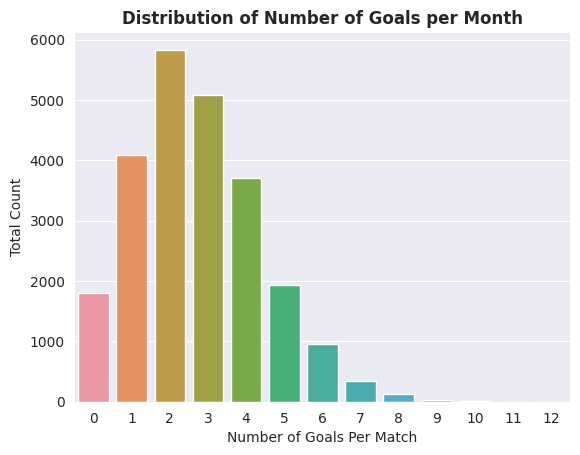

In [146]:
sns.countplot(x="goal", data=df_match)
plt.title("Distribution of Number of Goals per Month", fontweight='bold')
plt.ylabel("Total Count")
plt.xlabel("Number of Goals Per Match")
plt.show()

If we analyze the goals globally, there is a clear normal distribution, in which its center is at the value 2.

The next task to explore is the positions of the players that are determined by two values: X and Y.

To describe this section we have created some functions to visually represent the positions of the players during a match.

### We can draw the players for a particular match on the field-map

by setting the field as background picture and plotting player positions on the axis according to proportion of real ground positions.

In [147]:
def get_player_positions_to_draw(row):
    home = []
    away = []
    for team in ["home", "away"]:   
        for player in range(1,12):
            x_coord = row[team + "_player_X" + str(player)]
            y_coord = row[team + "_player_Y" + str(player)]
            if x_coord == 1 and y_coord == 1: x_coord = 5
            home.append([x_coord, y_coord]) if team == "home" else away.append([x_coord, 24-y_coord])
        
    return (home,away)

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.text as mpl_text
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def player_style(player=[], plot=None, teamType="away"):
    
    thecolor = "white"
    
    style = "x" if teamType == "away" else "+"
    title = "AWAY TEAM" if teamType == "away" else "HOME TEAM"
    coorx = 8 if teamType == "away" else 2
    coory = 23.3 if teamType == "away" else 0.6

    # put title of the plot
    plot.add_artist(
        mpl_text.Text(
            x = coorx,
            y = coory,
            text=title,
            color=thecolor,
            verticalalignment='center',
            horizontalalignment='center',
            fontsize=18
        )
    )

    # plot players on the plot
    for player in player:
        plot.add_artist(
            mpl_text.Text(
                x = player[0],
                y = player[1],
                text=style,
                color=thecolor,
                verticalalignment='center',
                horizontalalignment='center',
                fontsize=18
            )
        )
    

def plot_player_positions(home_player, away_player, venue_country):

    fig = plt.figure(figsize=(7,11), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')
    ax.set_xlim(0, 10) #Horizontal pitch size 
    ax.set_ylim(0, 24) #Vertical pitch size
    
    field_image = Image.open("/notebooks/images/football-pitch-back.jpeg")
    field_image = field_image.resize((392,600))
    
    flag1 = Image.open(f"/notebooks/flags/{venue_country.lower()}.png")
    flag1 = flag1.resize((16,16))
    
    ax.add_artist( #ax can be added image as artist.
    AnnotationBbox(
        OffsetImage(field_image), 
        (5, 12), 
        frameon=False
    ))
    
    ax.add_artist( #ax can be added image as artist.
        AnnotationBbox(
            OffsetImage(flag1), 
            (9.7, 12), 
            frameon=False
        ))
    ax.add_artist( #ax can be added image as artist.
        AnnotationBbox(
            OffsetImage(flag1), 
            (0.25, 12), 
            frameon=False
        ))

    player_style(home_player,ax, "home")
    player_style(away_player,ax, "away")

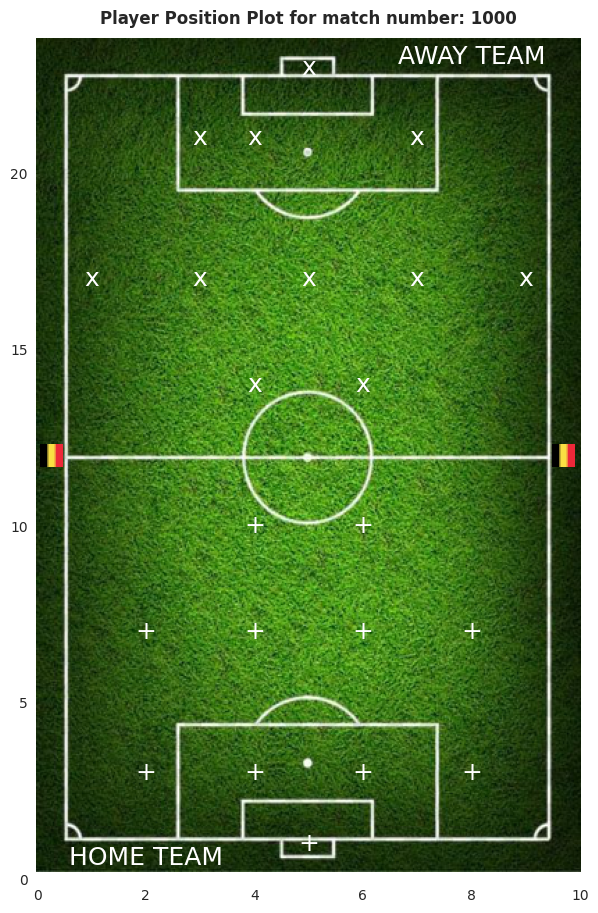

In [149]:
matchNumber = 1000  # the match at this number in the df_match is plotted
home,away = get_player_positions_to_draw(matches_by_country.iloc[matchNumber,:])
venue_country = matches_by_country.iloc[matchNumber,:]["Country"]
plot_player_positions(home, away, venue_country)
theTitle = "Player Position Plot for match number: " + str(matchNumber)
plt.title(theTitle, fontweight='bold')
plt.show()

This way we can show the position chosen by teams in a particular match. We can also see the flag of the hosting country / venue country where the league is held.

### Alternatively, we can also print the team player placement in a string format.

In [150]:
from collections import Counter
from functools import reduce

def get_team_formation(row=None,team=""):
    
    player_y = list()
    
    for i in range(2,12):
        player_y.append(row[team + '_player_Y' + str(i)])
    
    c_player = Counter(player_y)

    formation_list = Counter(sorted(c_player.elements())).values()
    formation = reduce(lambda x,y: str(x) + str(y),formation_list)

    return formation

In [151]:
home_team_positions = get_team_formation(df_match.iloc[1000,:],"home")
away_team_positions = get_team_formation(df_match.iloc[1000,:],"away")
print(f"Home team formation is '{home_team_positions}' whereas away team formation is '{away_team_positions}'")

Home team formation is '442' whereas away team formation is '352'


For instance of match number 1000, we see that the formation of home team is 442, which means how many players exist from the position closest to the goal to the center of the field.

**We then apply this transformation to the entire dataset. Also, we can check if there is any difference in player distribution depending on whether the team is local or not.**

In [152]:
df_match["home_formation"] = df_match.apply(lambda row: get_team_formation(row, "home"),axis=1)
df_match["away_formation"] = df_match.apply(lambda row: get_team_formation(row, "away"),axis=1)
df_match["home_formation"].value_counts()

4231     6381
442      6320
433      4332
451       931
4411      876
352       682
4312      680
4141      627
41212     557
4222      548
41221     371
343       283
4132      245
4321      239
532       186
3421      166
3412      145
3511      123
4123       75
541        69
4213       34
3232       13
3331        7
5311        2
1333        1
163         1
14221       1
Name: home_formation, dtype: int64

In [153]:
df_match["away_formation"].value_counts()

4231      6398
442       5970
433       4320
451       1212
4411       845
4141       705
352        692
4312       612
4222       541
41212      510
41221      365
343        281
4321       262
4132       231
532        191
3421       186
3511       147
541        135
3412       134
4123        89
4213        34
3232        16
3331        13
5311         2
31312        1
33211        1
133111       1
32311        1
Name: away_formation, dtype: int64

**In this case, it seems that there are no significant differences because in both cases the most used distribution is 4231.**

## Add column 'winning_team' that tells which team wins

In this dataset, the winning team is not shown, so we are going to generate a column to reflect the final result of the match: 1 (Home team wins), 2 (Draw) or 3 (Away team wins)

In [154]:
def assign_victory(row):
    
    winner = row["home_team_goal"] - row["away_team_goal"]
    
    if winner == 0:
        return "2"
    elif winner < 0:
        return "3"
    else:
        return "1"

In [155]:
df_match["winning_team"] = df_match.apply(assign_victory, axis = 1)

In [156]:
def getTeamResult(row):
    
    if row["winning_team"] == "1":
        home_team_result = 'Win'
        away_team_result = 'Loss'
    elif row["winning_team"] == "3":
        home_team_result = 'Loss'
        away_team_result = 'Win'
    else:
        home_team_result = 'Draw'
        away_team_result = 'Draw'
    
    return [home_team_result, away_team_result]

### Add columns 'home_team_result' and 'away_team_result' that tells if the particular home or away team wins in the match

In [157]:
df_match[["home_team_result", "away_team_result"]] = df_match.apply(getTeamResult, axis = 1, result_type="expand")

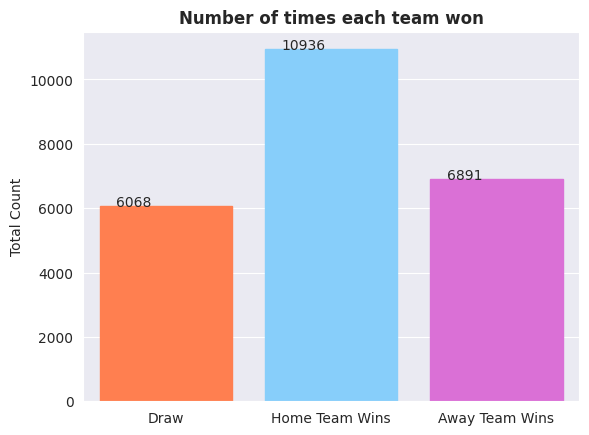

In [158]:
import math
ax = sns.countplot(x="winning_team", data=df_match)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1))
    if math.ceil(p.get_x()) == 0:
        p.set_color('#ff7f50') # color for Draw
    elif math.ceil(p.get_x()) == 1:
        p.set_color('#87cefa') # color for Home Team Wins
    else:
        p.set_color('#da70d6') # color for Away Team Wins

plt.title("Number of times each team won", fontweight='bold')
plt.ylabel("Total Count")
plt.xlabel("")
plt.xticks(ticks=[0,1,2], labels=['Draw','Home Team Wins','Away Team Wins'])
plt.show()

Observing these results, we highlight that **local teams have a greater tendency to win**.

In [159]:
# get the percentage of Home Team Wins, Draw and Away Team Wins out of total matches
df_match["winning_team"].value_counts(normalize=True)

1    0.457669
3    0.288387
2    0.253944
Name: winning_team, dtype: float64

With these data, we are going to find out if there are relationships between the results of a match and the distribution of the teams.

In [160]:
home_vs_away_df1 = pd.DataFrame()
home_vs_away_df2 = pd.DataFrame()

In [161]:
home_vs_away_df1[["formation", "result"]] = df_match[["home_formation","home_team_result"]].copy()
home_vs_away_df2[["formation", "result"]] = df_match[["away_formation","away_team_result"]].copy()

In [162]:
home_vs_away_df1 = pd.concat([home_vs_away_df1, home_vs_away_df2])
home_vs_away_df1.head()

formation result
match_api_id                 
493016             442   Draw
493017             442    Win
493018             442    Win
493020             442   Loss
493021             442    Win

## Null Hypothesis 1
**The 'formation' (initial position of player in the field) of team does not affect the 'result' of the match.**

The chi-square test for independence compares the observed frequencies of two categorical variables in a contingency table to the expected frequencies if the two variables were independent. The test statistic is the chi-squared statistic, which measures the difference between the observed and expected frequencies.

We use the chi2_contingency function from the scipy.stats library to perform the chi-square test for independence. The function takes a contingency table as input and returns the chi-squared statistic, the p-value, the degrees of freedom, and the expected frequencies.

In [163]:
from scipy.stats import chi2_contingency

result_vs_formation = pd.crosstab(home_vs_away_df1['result'], home_vs_away_df1['formation'])
chi2, p, dof, expected = chi2_contingency(result_vs_formation)
print("Chi-squared statistic: ", chi2)
print("p-value: ", p)

Chi-squared statistic:  254.30092721118618
p-value:  9.313010216363426e-26


The chi-squared statistic measures the difference between the observed frequencies of the two categorical variables in the contingency table and the expected frequencies if the two variables were independent. **A high chi-squared statistic indicates that the observed frequencies are significantly different from the expected frequencies, suggesting that the two variables are dependent.**

The p-value is the probability of observing a chi-squared statistic as extreme or more extreme than the one calculated, assuming that the null hypothesis is true. A small p-value (typically less than 0.05) indicates that it is unlikely to observe the observed frequencies if the two variables are independent, and thus provides evidence against the null hypothesis.

In your case, the chi-squared statistic is 774.5557129423786 and the **p-value is** 8.854981151263343e-125, which **is much smaller than 0.05**. This means that there is very strong evidence against the null hypothesis, which is that the formation doesn't affect the result. So we reject the null hypothesis and we can conclude that the formation and the result are dependent.

## Null Hypothesis 1 rejected

So in summary, **the formation value of the team does affect the result value**.

***
***
<br/>

Let us check the top 5 formations that lead to win

In [164]:
result_vs_formation = pd.crosstab(home_vs_away_df1['result'], home_vs_away_df1['formation'])
result_vs_formation.head()

formation  133111  1333  14221  163  31312  32311  3232  33211  3331  3412  \
result                                                                       
Draw            0     0      0    0      1      0     8      0     4    78   
Loss            0     1      0    1      0      1     6      0     7    99   
Win             1     0      1    0      0      0    15      1     9   102   

formation  ...  4231  4312  4321   433  4411   442  451  5311  532  541  
result     ...                                                           
Draw       ...  3243   331   131  2146   458  3014  575     1  100   49  
Loss       ...  4804   447   206  3027   695  4522  915     2  185  105  
Win        ...  4732   514   164  3479   568  4754  653     1   92   50  

[3 rows x 31 columns]

In [165]:
win_percentage = home_vs_away_df1.groupby('formation')['result'].apply(lambda x: (x == 'Win').mean())
top_formations = win_percentage.sort_values(ascending=False).head(5)
print(top_formations)

formation
133111    1.000000
14221     1.000000
33211     1.000000
3232      0.517241
3331      0.450000
Name: result, dtype: float64


We can see that 133111 only has 5 wins, so let us take only those formations which had atleast 100 wins, and then take the ones with top 5 percentage wins.

In [166]:
win_percentage = home_vs_away_df1.groupby('formation')['result'].apply(lambda x: (x == 'Win').mean())
result_count = home_vs_away_df1.groupby('formation')['result'].apply(lambda x: x.count())

formations_more_than_100_wins = win_percentage[result_count > 100]
top_formations = formations_more_than_100_wins.nlargest(5)
print(top_formations)

formation
4123    0.432927
4132    0.409664
433     0.402104
4312    0.397833
442     0.386819
Name: result, dtype: float64


Those formations which had atleast 100 wins, and then take the ones with bottom 5 percentage wins.

In [167]:
print(formations_more_than_100_wins.nsmallest(5))

formation
532     0.244032
541     0.245098
3511    0.296296
451     0.304713
4141    0.309309
Name: result, dtype: float64


#### We are going to try to see if there is any relationship between the result of a match and the number of cards, corners, passes...

In [168]:
card_result_df1 = pd.DataFrame()
card_result_df2 = pd.DataFrame()
card_result_df1[["cards","result"]] = df_match[["card_home", "home_team_result"]].copy()
card_result_df2[["cards","result"]] = df_match[["card_away", "away_team_result"]].copy()

In [169]:
card_result_df1 = pd.concat([card_result_df1, card_result_df2])
card_result_df1 = card_result_df1[card_result_df1["cards"] != -1]

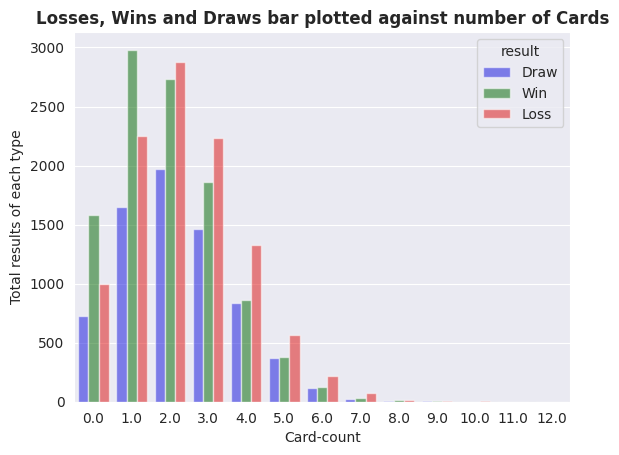

In [170]:
sns.countplot(x='cards', data=card_result_df1, hue='result',palette=["blue","green","red"],alpha=0.55)
plt.xlabel('Card-count')
plt.ylabel('Total results of each type')
plt.title('Losses, Wins and Draws bar plotted against number of Cards', fontweight='bold')
plt.show()

In the case of cards, we see that having many cards can mean losing a game.

Let's compare possession's effect on win.

In [171]:
possession_result_df1 = pd.DataFrame()
possession_result_df1[["possession","result"]] = df_match[["possession_home", "home_team_result"]].dropna().copy()
possession_result_df1 = possession_result_df1[possession_result_df1["possession"] != -1]
print(possession_result_df1.head())

              possession result
match_api_id                   
489042             54.75   Draw
489043             64.25    Win
489044             45.50   Loss
489045             49.75    Win
489046             51.50    Win


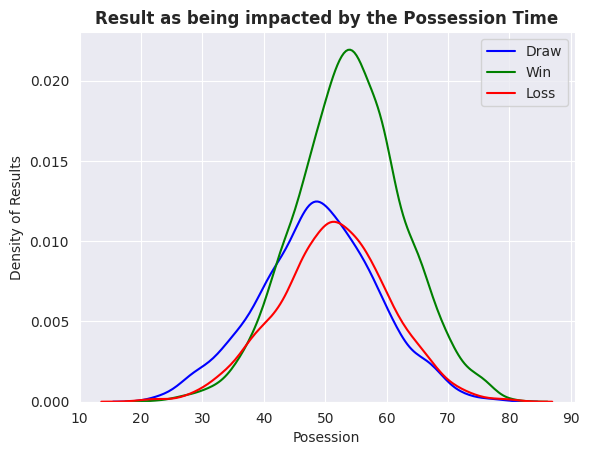

In [172]:
g = sns.kdeplot(data=possession_result_df1, x="possession", hue="result",palette=["red","green","blue"])
new_labels = ['Draw','Win',"Loss"]
plt.ylabel("Density of Results")
plt.xlabel("Posession")
plt.legend(labels=new_labels)
plt.title('Result as being impacted by the Possession Time', fontweight='bold')
plt.show()

Visually it appears that a greater possession can affect the victory of the game.
Let us form a hypothesis over this and test it.

***
***
<br/>

## Null Hypothesis 2
**The 'possession' (minutes for which ball is in possession by players of a team) does not affect the 'result' of the match.**

In [173]:
from scipy.stats import chi2_contingency

result_vs_possession = pd.crosstab(possession_result_df1['result'], possession_result_df1['possession'])
chi2, p, dof, expected = chi2_contingency(result_vs_possession)
print("Chi-squared statistic: ", chi2)
print("p-value: ", p)

Chi-squared statistic:  1550.251125677174
p-value:  6.861119670945305e-17


The conclusion is that the null hypothesis (that possession does not affect the result of the match) is rejected. The low p-value (6.86e-17) indicates that there is a strong evidence against the null hypothesis and in favor of an alternative hypothesis that possession affects the result of the match.

The chi-squared statistic indicates how much the observed data deviates from the expected data under the null hypothesis. In this case, a high value of chi-squared statistic (1550.25) suggests that there is a significant difference between the observed and expected frequency distribution of the variables 'result' and 'possession' in the contingency table. This, in turn, supports the rejection of the null hypothesis.

## Null Hypothesis 2 rejected

So in summary, **the minutes of possession of ball by the team does affect the result of the game**.

***
***
<br/>

## Null Hypothesis 3

Our third null hypothesis is that number of corners seems dictates whether a team will win or lose.

In [174]:
corner_result_df1 = pd.DataFrame()
corner_result_df1[["corner","result"]] = df_match[["corner", "home_team_result"]].copy()
print(corner_result_df1.head())
print(corner_result_df1.shape)
for index, row in corner_result_df1.iterrows():
    if row["corner"] is not None:
        print(row["corner"])
        break

             corner result
match_api_id              
493016         None   Draw
493017         None    Win
493018         None    Win
493020         None   Loss
493021         None    Win
(23895, 2)
<corner><value><stats><corners>1</corners></stats><event_incident_typefk>329</event_incident_typefk><elapsed>19</elapsed><subtype>cross</subtype><player1>38807</player1><sortorder>0</sortorder><team>10261</team><n>280</n><type>corner</type><id>378960</id></value><value><stats><corners>1</corners></stats><event_incident_typefk>330</event_incident_typefk><elapsed>22</elapsed><subtype>short</subtype><player1>40565</player1><sortorder>0</sortorder><team>10261</team><n>263</n><type>corner</type><id>378992</id></value><value><stats><corners>1</corners></stats><event_incident_typefk>329</event_incident_typefk><elapsed>22</elapsed><subtype>cross</subtype><player1>38807</player1><sortorder>4</sortorder><team>10261</team><n>293</n><type>corner</type><id>378996</id></value><value><stats><corners>1</c

In [175]:
import xml.etree.ElementTree as ET

def get_total_corners_in_match(row):
    if row != None:
        root = ET.fromstring(row)
        corners = []
        for value in root.findall('./value'):
            corner = value.find('./stats/corners').text
            corners.append(corner)
        
    return len(corners)

In [176]:
corner_list = []
for index, row in corner_result_df1.iterrows():
    if row["corner"] is not None:
            corner_list.append(get_total_corners_in_match(row["corner"]))
    else:
        corner_list.append(0)
        
corner_result_df1["corner"] = corner_list
        
corner_result_df1.head()

corner result
match_api_id               
493016             0   Draw
493017             0    Win
493018             0    Win
493020             0   Loss
493021             0    Win

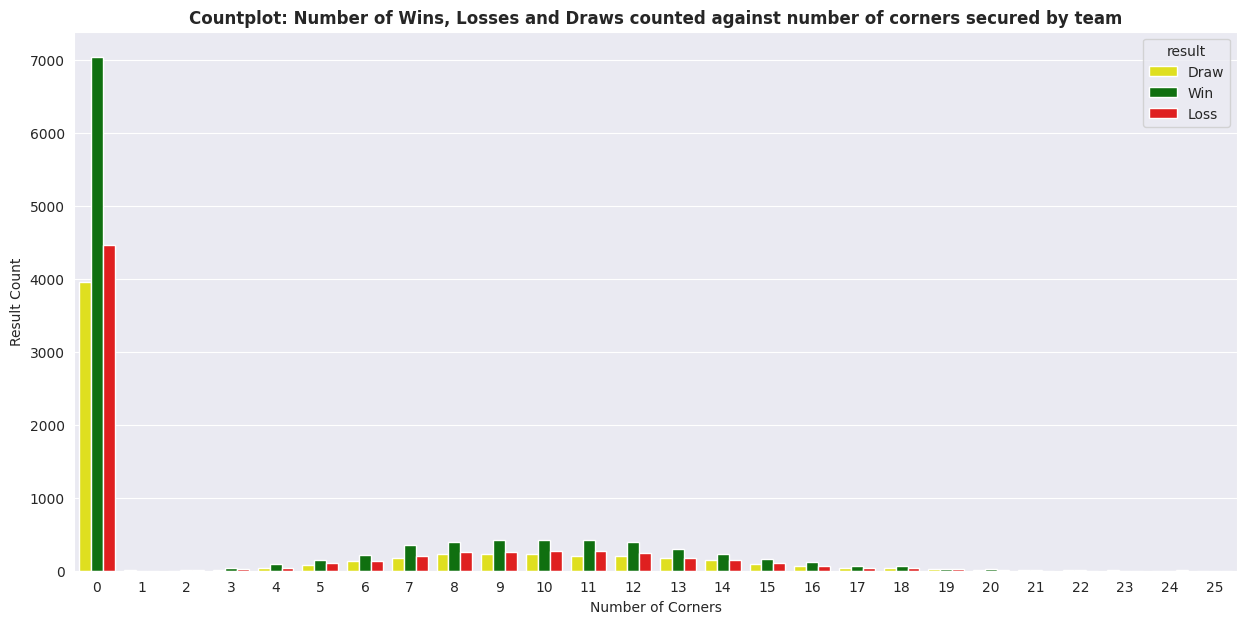

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
sns.countplot(x='corner', hue='result', data=corner_result_df1, palette={"Loss": "red", "Win": "green", "Draw": "yellow"})
plt.title('Countplot: Number of Wins, Losses and Draws counted against number of corners secured by team', fontweight='bold')
plt.ylabel("Result Count")
plt.xlabel("Number of Corners")
plt.show()

In [178]:
from scipy.stats import chi2_contingency

corner_result_df1 = pd.crosstab(corner_result_df1['result'], corner_result_df1['corner'])
chi2, p, dof, expected = chi2_contingency(corner_result_df1)
print("Chi-squared statistic: ", chi2)
print("p-value: ", p)

Chi-squared statistic:  60.967713309308095
p-value:  0.1376172284046842


The conclusion from the output is that there is not enough evidence to reject the null hypothesis, as the p-value of 0.1376 is greater than the commonly used significance level of 0.05. This means that there is not a significant association between the result and corner variables in the data.

## Null Hypothesis 3 Accepted

In summary, we conclude that **the number of corners in a match do not impact the result of the match.**
<br/>
***
***

<br />Other relationships that we can analyze is the streak, that is, whether the previous results of a team influence or not. To do this, we are going to compare the result of a match with its two previous ones.

In [179]:
def find_last_result(row, dataframe, team, element=0):
    team_id = row[team + "_team_api_id"]
    season = row["season"]
    date = row["date"]

    mask = (dataframe["season"] == season) & ((dataframe["home_team_api_id"] == team_id) | (dataframe["away_team_api_id"] == team_id)) & (dataframe["date"] < date)
    candidates = dataframe[mask]
    if len(candidates) <= 0:
        return np.nan
    last_result = candidates.nlargest(element + 1, 'date')
    if len(last_result) <= element:
        return np.nan
    return last_result.loc[last_result.index[element], team + "_team_result"]

We look for the result before the current match.

In [180]:
df_match['date'] = pd.to_datetime(df_match['date'])

In [181]:
# we take this approach as this is calculation intensive
# if ./csv/df_match_last_result.csv exists, load the dataframe from the csv file
if os.path.isfile('./csv/df_match_last_result.csv'):
    df_match = pd.read_csv('./csv/df_match_last_result.csv', parse_dates=['date'])
else:
    df_match["home_1st_last_result"] = df_match.apply(lambda row: find_last_result(row,df_match,"home",0),axis=1)
    df_match["away_1st_last_result"] = df_match.apply(lambda row: find_last_result(row,df_match,"away",0),axis=1)
    # save the dataframe to a new csv file
    df_match.to_csv('./csv/df_match_last_result.csv', index=False)

In [182]:
result_by_time1 = pd.DataFrame()
result_by_time2 = pd.DataFrame()

In [183]:
result_by_time1["1st_last_result"] = df_match["home_1st_last_result"].copy()
result_by_time1["current_result"] = df_match["home_team_result"].copy()

result_by_time2["1st_last_result"] = df_match["away_1st_last_result"].copy()
result_by_time2["current_result"] = df_match["away_team_result"].copy()

In [184]:
result_by_time1 = pd.concat([result_by_time1, result_by_time2])

In [185]:
result_by_time1.shape

(47790, 2)

In [186]:
pd.crosstab(result_by_time1["1st_last_result"],result_by_time1["current_result"])

current_result   Draw  Loss   Win
1st_last_result                  
Draw             3014  4548  4311
Loss             4350  6240  6660
Win              4378  6538  6351

## Null Hypothesis 4
We propose that the distribution of the current result is independent of the distribution of the first/last result.

In [187]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create the contingency table
table = pd.crosstab(result_by_time1["1st_last_result"], result_by_time1["current_result"])

# Perform the chi-squared test
stat, p, dof, expected = chi2_contingency(table)

# Check the p-value
if p < 0.05:
    print("The null hypothesis can be rejected, meaning there is evidence of a significant association between the two variables.")
else:
    print("The null hypothesis cannot be rejected, meaning there is no evidence of a significant association between the two variables.")

The null hypothesis can be rejected, meaning there is evidence of a significant association between the two variables.


Analyzing the current results of a match with the previous one, we could draw the following conclusions:

- If the previous result was a draw, then in the next match you will most likely be a loss or a win.
- If the previous result was to lose, then in the next match it is most likely to win.
- If the previous result was to win, then in the next match you will most likely lose.

As we can see, it seems that there is a relationship between the result of a match and its previous one.

## Null Hypothesis 4 rejected
In summary, **there is a significant association between the result of the previous match and the current match result.**

***
***
<br/>

In [188]:
import lxml.etree as ET

def extract_goal_data(goal_xml):
    """Extracts the relevant information about a goal from the XML data."""
    # parse the XML data
    root = ET.fromstring(goal_xml)
    # get the value elements
    values = root.findall('./value')
    # create a list to store the goal data
    goals = []
    # iterate over the value elements
    for value in values:
        # create a dictionary to store the goal data
        goal_data = {}
        # extract the id of the goal
        id_element = value.find('id')
        if id_element is not None:
            goal_data['id'] = id_element.text
        # extract the type of the goal
        type_element = value.find('type')
        if type_element is not None:
            goal_data['type'] = type_element.text
        # extract the team that scored the goal
        team_element = value.find('team')
        if team_element is not None:
            goal_data['team'] = team_element.text
        # extract the first player involved in the goal
        player1_element = value.find('player1')
        if player1_element is not None:
            goal_data['player1'] = player1_element.text
        # extract the second player involved in the goal
        player2_element = value.find('player2')
        if player2_element is not None:
            goal_data['player2'] = player2_element.text
        # extract the subtype of the goal
        subtype_element = value.find('subtype')
        if subtype_element is not None:
            goal_data['subtype'] = subtype_element.text
        # extract the elapsed time of the goal
        elapsed_element = value.find('elapsed')
        if elapsed_element is not None:
            goal_data['elapsed'] = elapsed_element.text
        # add the goal data to the list
        goals.append(goal_data)
    # return the list of goals
    return goals

# apply the extract_goal_data function to each row in the goal column
df_match_light['goals'] = df_match_light['goal'].apply(extract_goal_data)

# print the first five rows of the goals column
print(df_match_light['goals'].head(5))

match_api_id
489042                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [{'id': '378998', 'type': 'goal', 'team': '10261', 'player1': '37799', 'player2': '38807', 'subtype': 'header', 'elapsed': '22'}, {'id': '379019', 'type': 'goal', 'team': '10260', 'player1': '24148', 'player2': '24154', 'subtype': 'shot', 'elapsed': '24'}]
489043                                                                                                                                                                                                                                                     

In [189]:
import pandas as pd
import re
from collections import Counter

# compile a regular expression to match player values
player_re = re.compile(r'player\d+')

# explode the goals column to create a new row for each goal
df_exploded = df_match_light.explode('goals')

# create an empty Counter to store the goal counts
goal_counts = Counter()

# define a function to extract the players from a goal
def extract_players(goal):
    players = []
    # check if the goal is a dictionary
    if isinstance(goal, dict):
        # iterate over the items in the goal dictionary
        for key, value in goal.items():
            # check if the key matches the player pattern
            if player_re.match(key):
                players.append(value)
    return players

# apply the extract_players function to each row of the goals column
players = df_exploded['goals'].apply(extract_players)

# iterate over the players and update the goal counts
for player_list in players:
    for player in player_list:
        goal_counts[player] += 1

# print the player with the highest goal count
print(goal_counts.most_common(1))

[('30981', 383)]


In [190]:
import pandas as pd

# get the top 5 players by goal count
top_players = goal_counts.most_common(5)

# create a DataFrame from the records in the Counter
highest_scoring_players = pd.DataFrame.from_records(top_players, columns=['player_id', 'total_goals_scored'])

# print the DataFrame
print(highest_scoring_players)

  player_id  total_goals_scored
0     30981                 383
1     30893                 354
2     35724                 257
3     25759                 204
4     37412                 194


In [191]:
df_player.describe()

birthday           BMI
count  11060.000000  11060.000000
mean    1986.642857     23.061806
std        5.481362      1.316878
min     1967.000000     17.586568
25%     1983.000000     22.170941
50%     1987.000000     23.051962
75%     1991.000000     23.867438
max     1999.000000     30.860445

In [192]:
df_player = football_db["Player"].copy()

In [193]:
df_player['player_api_id'] = df_player['player_api_id'].map(str)
df_player['player_name'] = df_player['player_name'].map(str)

In [194]:
# for each of the values in column player_id in the highest_scoring_players DataFrame
for player_id in highest_scoring_players['player_id']:
    row = df_player[df_player['player_api_id'] == player_id]
    player_name = row['player_name'].values[0]
    # add player_name to player_name in highest_scoring_players where player_id matches current player_id
    highest_scoring_players.loc[highest_scoring_players['player_id'] == player_id, 'player_name'] = player_name

print(highest_scoring_players)

  player_id  total_goals_scored         player_name
0     30981                 383        Lionel Messi
1     30893                 354   Cristiano Ronaldo
2     35724                 257  Zlatan Ibrahimovic
3     25759                 204     Gonzalo Higuain
4     37412                 194       Sergio Aguero


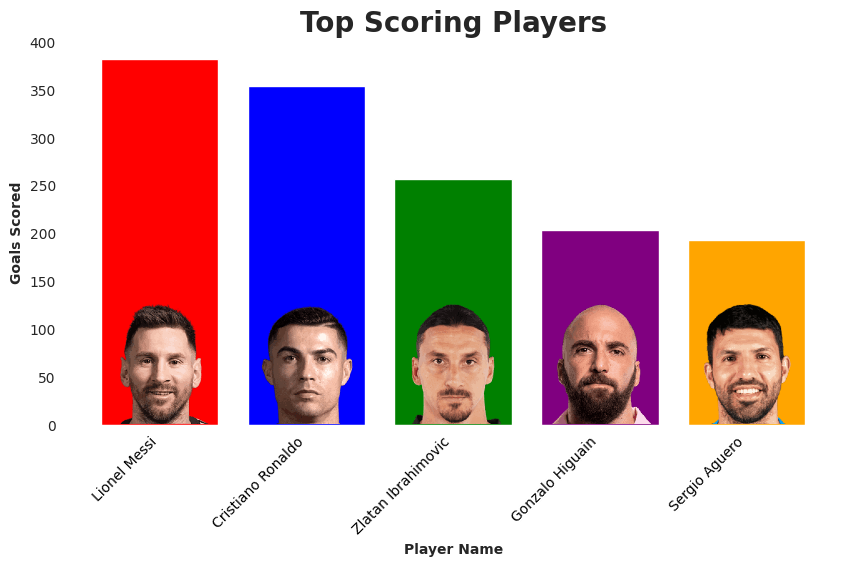

In [195]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython import display
from io import BytesIO
import IPython

# Sort the dataframe by total_goals_scored in descending order
highest_scoring_players = highest_scoring_players.sort_values(by='total_goals_scored', ascending=False)

player_names = highest_scoring_players['player_name'].values.tolist()
goals_scored = highest_scoring_players['total_goals_scored'].values.tolist()
player_ids = highest_scoring_players['player_id'].values.tolist()

# Create a list of x-axis values
x_values = range(len(goals_scored))

colors = ['red', 'blue', 'green', 'purple', 'orange']

fig = plt.figure(figsize=(10,5), facecolor='white')
ax = fig.add_subplot(111, facecolor='white')

# Add axis labels and a title
plt.xlabel('Player Name', fontweight='bold')
plt.ylabel('Goals Scored', fontweight='bold')
plt.title('Top Scoring Players', fontweight='bold', fontsize=20)

# Label the x-axis with the player names
plt.xticks(x_values, player_names, rotation=45, color='black' , ha='right', rotation_mode='default')

for i in range(len(x_values)):
    
    response = requests.get(f'https://images.fotmob.com/image_resources/playerimages/{player_ids[i]}.png')
    im = plt.imread(BytesIO(response.content))
    imagebox = OffsetImage(im, zoom = 0.45)
    ab = AnnotationBbox(imagebox, (x_values[i], 64), frameon = False)
    ax.bar(x_values[i], goals_scored[i], color=colors[i])
    ax.add_artist(ab)

# Show the plot
plt.show()

Prepareing data for csv export for Google LookerStudio (formerly Google Dashboard)
Remember, in the beginning, we had the following dataframes loaded from the database tables:
- df_team
- df_country
- df_league
- df_match
- df_player
- df_player_attr
- df_team_attr

We will check the columns in each of them and drop the ones we do not need. We will append 'clean' to the df name after cleaning them of un-needed columns

In [196]:
# print a list of all the column names
print(list(df_match.columns))

['country_id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5

In [197]:
df_match_clean = df_match.drop(columns=['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'goal', 'card', 'cross', 'corner', 'possession', 'shoton', 'shotoff', 'foulcommit'], inplace=False)
print(list(df_match_clean.columns))

['country_id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'shoton_away', 'shoton_home', 'homewin', 'shotoff_away', 'shotoff_home', 'foulcommit_home', 'foulcommit_away', 'card_home', 'card_away', 'cross_home', 'cross_away', 'possession_home', 'possession_away', 'home_formation', 'away_formation', 'winning_team', 'home_team_result', 'away_team_result', 'home_1st_last_result', 'away_1st_last_result']


In [198]:
df_match_clean.head()

country_id  season  stage       date  home_team_api_id  away_team_api_id  \
0           1    2008     24 2009-02-28              9996              8635   
1           1    2008     24 2009-02-27              8203              9987   
2           1    2008     24 2009-02-28              9986              9998   
3           1    2008     24 2009-03-01              9994              9991   
4           1    2008     24 2009-02-28              8342              9999   

   home_team_goal  away_team_goal  shoton_away  shoton_home  ...  cross_away  \
0               1               1          NaN          NaN  ...         NaN   
1               2               1          NaN          NaN  ...         NaN   
2               3               0          NaN          NaN  ...         NaN   
3               0               1          NaN          NaN  ...         NaN   
4               2               1          NaN          NaN  ...         NaN   

   possession_home  possession_away  home_formation  away_formation  \
0              NaN              NaN             442             442   
1              NaN              NaN             442             442   
2              NaN              NaN             442             442   
3              NaN              NaN             442             442   
4              NaN              NaN             442             442   

   winning_team  home_team_result  away_team_result  home_1st_last_result  \
0             2              Draw              Draw                   NaN   
1             1               Win              Loss                   NaN   
2             1               Win              Loss                   NaN   
3             3              Loss               Win                   NaN   
4             1               Win              Loss                   NaN   

   away_1st_last_result  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 28 columns]

Export df_match_clean as csv so that Google Looker can be populated.

In [199]:
# saving the dataframe
df_match_clean.to_csv('./csv/df_match_clean.csv')

In [200]:
print(df_country.head(15))

              name
id                
1          Belgium
1729       England
4769        France
7809       Germany
10257        Italy
13274  Netherlands
15722       Poland
17642     Portugal
19694     Scotland
21518        Spain
24558  Switzerland


In [201]:
!mkdir -p pandasprofiling

In [202]:
import os

if not os.path.exists("./pandasprofiling/output.html"):

    import warnings
    warnings.filterwarnings("ignore", message="The input array could not be properly checked for nan values. nan values will be ignored.")

    from pandas_profiling import ProfileReport

    prof = ProfileReport(df_match_clean)
    prof.to_file(output_file='./pandasprofiling/output.html')

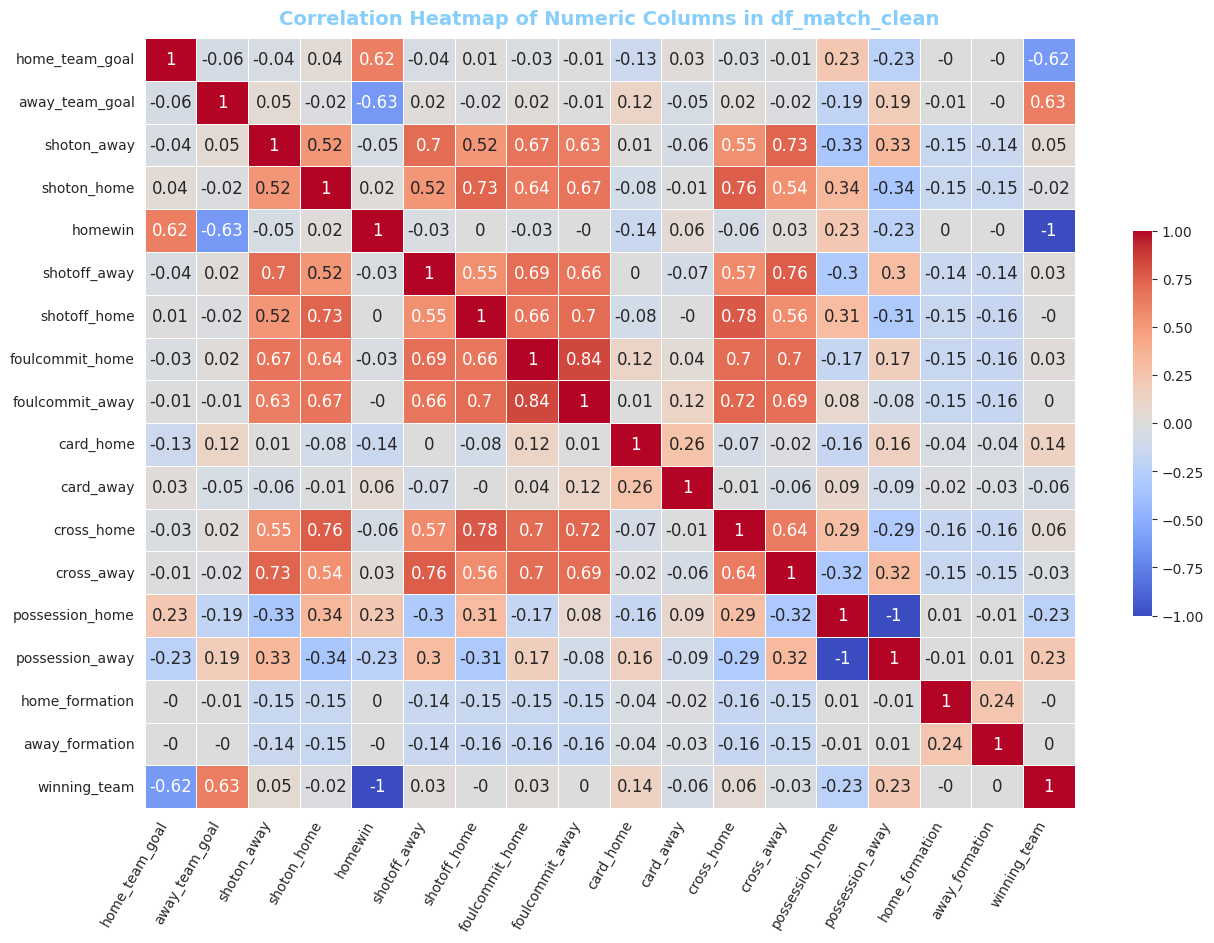

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# if we wanted all the coulmns, we would have done this
# corr = df_match_clean.corr(numeric_only=True)

# as we do not need the following columns to be plotted in heatmap: country_id	season	stage	date	home_team_api_id	away_team_api_id
corr = df_match_clean.iloc[:, 6:].corr(numeric_only=True)

# round to 2 decimal points for easy display
corr = np.round(corr, 2)
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, annot_kws={'fontsize': 12}, cbar_kws={'shrink': 0.5})
plt.title("Correlation Heatmap of Numeric Columns in df_match_clean", fontweight='bold', fontsize=14, pad=10, color='#87CEFA')
plt.xticks(rotation=60, ha='right', rotation_mode='default')
plt.show()

## Observations from heatmap

- strong positive correlations:
    - When any team in the match takes a lot of attempts at the goal, the other team also responds by proportionally increasing their attempts at the goal.
    - When the players corss (pass) the ball between them a lot, they are able to take more shots at the goal, and vice versa.

- positive coorelations:
    - The more shots a team takes at the goal, the more fouls they are also expected to commit

As there is no direct co-relation found between our target-variable, to predict the 'home-win' and any other column, so we may need to train a ML model.

In [204]:
def run_h2o_automl(dataframe, variable_to_predict,
                   max_number_models):
    """
    This function initiates an h2o cluster, converts
    the dataframe to an h2o dataframe, and then runs
    the autoML function to generate a list of optimal 
    predictor models. The best models are displayed via a 
    scoreboard.
    Arguments:
        dataframe: Pandas dataframe. 
        variable_to_predict: String. Name of the dataframe that we're predicting.
        max_number_models: Int. Total number of models to run.
    Outputs:
        Leader board of best performing models in the console, plus performance of
        best fit model on the test data, including confusion matrix
    """
    h2o.init()
    #Convert the dataframe to an h2o dataframe
    dataframe = h2o.H2OFrame(dataframe)
    #Convert the variable we're predicting to a factor; otherwise this
    #will run as a regression problem
    dataframe[variable_to_predict] = dataframe[variable_to_predict].asfactor()
    #Declare the x- and y- variables for the database. 
    #x-variables are predictor variables, and y-variable is what
    #we wish to predict
    x = dataframe.columns
    y = variable_to_predict
    x.remove(y)
    #Pull the training and test data out at a 75/25 split.
    train, test, validate = dataframe.split_frame(ratios=[.75, .125])
    # Run AutoML (limited to 1 hour max runtime by default)
    aml = H2OAutoML(max_models=max_number_models, seed=1)
    aml.train(x=x, y=y, training_frame = train, validation_frame = validate)
    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb.head(rows=lb.nrows))
    #Get performance on test data
    performance = aml.leader.model_performance(test)
    print(performance)

In [205]:
#run_h2o_automl(dataframe=df_match_clean, 
#               variable_to_predict='homewin',
#               max_number_models=10)

In [206]:
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier
    from tpot import TPOTClassifier

In [207]:
def run_tpot_automl(dataframe, 
                    variable_to_predict, 
                    number_generations,
                    population = 20,
                    file_to_export_pipeline_to = 'tpot_classifier_pipeline.py'):
    """
    This function runs a TPOT classifier on the dataset, after splitting into
    a training and test set, and then oversampling the training set.
    Args:
        dataframe: pandas dataframe. Master dataframe containing the feature and target
        data
        variable_to_predict: String. Name of the target variable that we want to predict.
        number_of_generations: Int. Number of generations to iterate through.
    Outputs:
        File containing the machine learning pipeline for the best performing model.
    """
    #Remvoe the target column to get the features dataframe
    features_dataframe = dataframe.loc[:, dataframe.columns != variable_to_predict]
    X_train, X_test, y_train, y_test = train_test_split(features_dataframe, dataframe[variable_to_predict],
                                                    train_size=0.75, test_size=0.25)
    #Run the TPOT pipeline
    tpot = TPOTClassifier(generations= number_generations, population_size=population, verbosity=2)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export(file_to_export_pipeline_to)

## Next Steps
- convert some columns like home_team_win to appropriate numbers like 1, 2 and 3
- make some dimentionality reduction by using mentioned techniques
- convert home_team_api_id to home_team and away_team_api_id to away_team and replace ids with names of team for good Looker.
- export the csv then import to Google Looker to create dashboard
- train an ML model

In [208]:
# make a copy of df_match_clean and call ir df_match_c_numeric
df_match_c_numeric = df_match_clean.copy()

# convert the predictor variables in columns 'home_team_result', 'away_team_result', 'home_1st_last_result', 'away_1st_last_result' to numeric by using the map function, and then convert the result to int, as the map function returns a float, and follow the map where 1 = win, 0 = draw, -1 = loss
df_match_c_numeric['home_team_result'] = df_match_c_numeric['home_team_result'].map({'Win': 1, 'Draw': 0, 'Loss': -1})
df_match_c_numeric['away_team_result'] = df_match_c_numeric['away_team_result'].map({'Win': 1, 'Draw': 0, 'Loss': -1})
df_match_c_numeric['home_1st_last_result'] = df_match_c_numeric['home_1st_last_result'].map({'Win': 1, 'Draw': 0, 'Loss': -1})
df_match_c_numeric['away_1st_last_result'] = df_match_c_numeric['away_1st_last_result'].map({'Win': 1, 'Draw': 0, 'Loss': -1})

# print random 15 rows of df_match_c_numeric
df_match_c_numeric.sample(10)

country_id  season  stage       date  home_team_api_id  \
19700       21518    2008      2 2008-09-13             10281   
23670       24558    2014     31 2015-05-03             10243   
2530         1729    2010     33 2011-04-26             10194   
20835       21518    2011     21 2012-01-28              8633   
21643       21518    2013     26 2014-03-02             10205   
15253       15722    2013     14 2013-10-30              8021   
2515         1729    2010     32 2011-04-10             10252   
22973       24558    2010     32 2011-05-07             10199   
6843         4769    2014     13 2014-11-08              7819   
19379       19694    2015     12 2015-10-24              8066   

       away_team_api_id  home_team_goal  away_team_goal  shoton_away  \
19700              9906               2               1          0.0   
23670             10192               0               1          NaN   
2530               8602               3               0          1.0   
20835              8394               3               1          2.0   
21643              8603               1               1          0.0   
15253              8030               1               3          NaN   
2515              10261               1               0          5.0   
22973             10192               1               1          NaN   
6843               9830               1               2          4.0   
19379              8467               0               1          NaN   

       shoton_home  ...  cross_away  possession_home  possession_away  \
19700          0.0  ...         0.0              NaN              NaN   
23670          NaN  ...         NaN              NaN              NaN   
2530           5.0  ...        22.0        54.500000        45.500000   
20835          2.0  ...         8.0        71.166667        28.833333   
21643          0.0  ...         0.0              NaN              NaN   
15253          NaN  ...         NaN              NaN              NaN   
2515           5.0  ...        18.0        46.750000        53.250000   
22973          NaN  ...         NaN              NaN              NaN   
6843           4.0  ...         7.0        54.000000        46.000000   
19379          NaN  ...         NaN              NaN              NaN   

       home_formation  away_formation  winning_team  home_team_result  \
19700            4231            4231             1                 1   
23670             442            4231             3                -1   
2530              442            4231             1                 1   
20835            4231            4231             1                 1   
21643             442             343             2                 0   
15253            4321            4231             3                -1   
2515              442             442             1                 1   
22973             442             343             2                 0   
6843              442            4231             3                -1   
19379            4231            4231             3                -1   

       away_team_result  home_1st_last_result  away_1st_last_result  
19700                -1                   1.0                  -1.0  
23670                 1                  -1.0                   0.0  
2530                 -1                   0.0                   0.0  
20835                -1                   1.0                   0.0  
21643                 0                  -1.0                   1.0  
15253                 1                   1.0                   0.0  
2515                 -1                   0.0                  -1.0  
22973                 0                   1.0                   1.0  
6843                  1                   1.0                   0.0  
19379                 1                   1.0                   1.0  

[10 rows x 28 columns]

In [209]:
print(df_match_c_numeric.columns.tolist())

['country_id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'shoton_away', 'shoton_home', 'homewin', 'shotoff_away', 'shotoff_home', 'foulcommit_home', 'foulcommit_away', 'card_home', 'card_away', 'cross_home', 'cross_away', 'possession_home', 'possession_away', 'home_formation', 'away_formation', 'winning_team', 'home_team_result', 'away_team_result', 'home_1st_last_result', 'away_1st_last_result']


As we will select 'homewin' as target variable, we should delete the columns that give direct clue to the homewin. To do this, we create a new dataframe named df_match_cantsee

In [210]:
df_match_cantsee = df_match_c_numeric.copy()

# we should drop the totally useless as well as the columns which have direct mathematical relationship with the target variable
# drop country_id	season	date	home_team_api_id	away_team_api_id  home_team_goal	away_team_goal  home_team_result	away_team_result

df_match_cantsee.drop(['country_id', 'season', 'date', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_team_result', 'away_team_result', 'winning_team'], axis=1, inplace=True)
print(df_match_cantsee.columns.tolist())
# print random 15 rows of df_match_cantsee
df_match_cantsee.sample(10)

['stage', 'shoton_away', 'shoton_home', 'homewin', 'shotoff_away', 'shotoff_home', 'foulcommit_home', 'foulcommit_away', 'card_home', 'card_away', 'cross_home', 'cross_away', 'possession_home', 'possession_away', 'home_formation', 'away_formation', 'home_1st_last_result', 'away_1st_last_result']


stage  shoton_away  shoton_home  homewin  shotoff_away  shotoff_home  \
14029     12          NaN          NaN        1           NaN           NaN   
22549      4          8.0          4.0       -1           4.0           3.0   
14099      2          NaN          NaN       -1           NaN           NaN   
12090      3          0.0          0.0       -1           0.0           0.0   
16686      6          NaN          NaN        1           NaN           NaN   
6784       8          0.0          0.0       -1           0.0           0.0   
1148      23          NaN          NaN       -1           NaN           NaN   
4681      22          NaN          NaN       -1           NaN           NaN   
20450     20          0.0          0.0        1           0.0           0.0   
2420      23          4.0          8.0        1           1.0          15.0   

       foulcommit_home  foulcommit_away  card_home  card_away  cross_home  \
14029              NaN              NaN        NaN        NaN         NaN   
22549             15.0             16.0        3.0        3.0        21.0   
14099              NaN              NaN        NaN        NaN         NaN   
12090              0.0              0.0        5.0        3.0         0.0   
16686              NaN              NaN        NaN        NaN         NaN   
6784               0.0              0.0        1.0        1.0         0.0   
1148               NaN              NaN        NaN        NaN         NaN   
4681               NaN              NaN        NaN        NaN         NaN   
20450              0.0              0.0        3.0        4.0         0.0   
2420              11.0              8.0        1.0        0.0        44.0   

       cross_away  possession_home  possession_away  home_formation  \
14029         NaN              NaN              NaN             433   
22549        11.0            53.25            46.75            4231   
14099         NaN              NaN              NaN             442   
12090         0.0              NaN              NaN             352   
16686         NaN              NaN              NaN             433   
6784          0.0              NaN              NaN            4231   
1148          NaN              NaN              NaN             433   
4681          NaN              NaN              NaN             433   
20450         0.0              NaN              NaN            4231   
2420         13.0            61.75            38.25             433   

       away_formation  home_1st_last_result  away_1st_last_result  
14029             433                   1.0                   0.0  
22549            4231                   1.0                   1.0  
14099             442                   0.0                   1.0  
12090             352                   0.0                   1.0  
16686            4231                  -1.0                   0.0  
6784             4231                   1.0                  -1.0  
1148             4222                  -1.0                   0.0  
4681              451                   0.0                   1.0  
20450            4231                   0.0                  -1.0  
2420             4411                   1.0                  -1.0

## PCA: only for auditors

As we can see, that :
- we can manually eliminate columns. 
- The data-model is not too heavy due to heavy feature manipulation and selection. 
- The co-relation between columns is not high enough for PCA or other feature reduction techniques to be useful here. It blinds us to the real output rather than enhance it in this case.

However, as this is requirement of the project, we do it.

No standardization is needed for PCA as the data is true numberic and not a measurement against a selected scale like KG or Miles. Most of the data represents number of incidents that does not require feature standardization before PCA.

In [211]:
# make a copy of df_match_cantsee and call it df_match_cantsee_notnan
df_match_cantsee_notnan = df_match_cantsee.copy()

# drop all rows with NaN values
df_match_cantsee_notnan.dropna(inplace=True)

##### Remove NaN values to prevent the following error in PCA:

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [212]:
x = df_match_cantsee_notnan.drop('homewin', axis=1)
y = df_match_cantsee_notnan['homewin']

In [213]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])

In [214]:
finalDf = pd.concat([principalDf, df_match_cantsee[['homewin']]], axis = 1)

In [215]:
from IPython.display import Image, display

# only run this if tpot_classifier_pipeline_pop20.py is not already in the directory
pipeline_output_file_name = 'tpot_classifier_pipeline_pop120'
if f'{pipeline_output_file_name}.py' not in os.listdir():
    run_tpot_automl(dataframe =  df_match_cantsee, 
                        variable_to_predict = 'homewin',
                        number_generations = 4,
                        population = 100,
                        file_to_export_pipeline_to = f"{pipeline_output_file_name}.py")
    print("Remember to take the screenshot of this performance metrics and store it in the relevant filename")

# image display does not work from inside if else conditionals
from PIL import Image
#Image.open(f"{pipeline_output_file_name}.png")

### Compare perfomance to coorelation matrix:
Check if model's performance is significantly better than simple co-relation of homewin column to any other column.

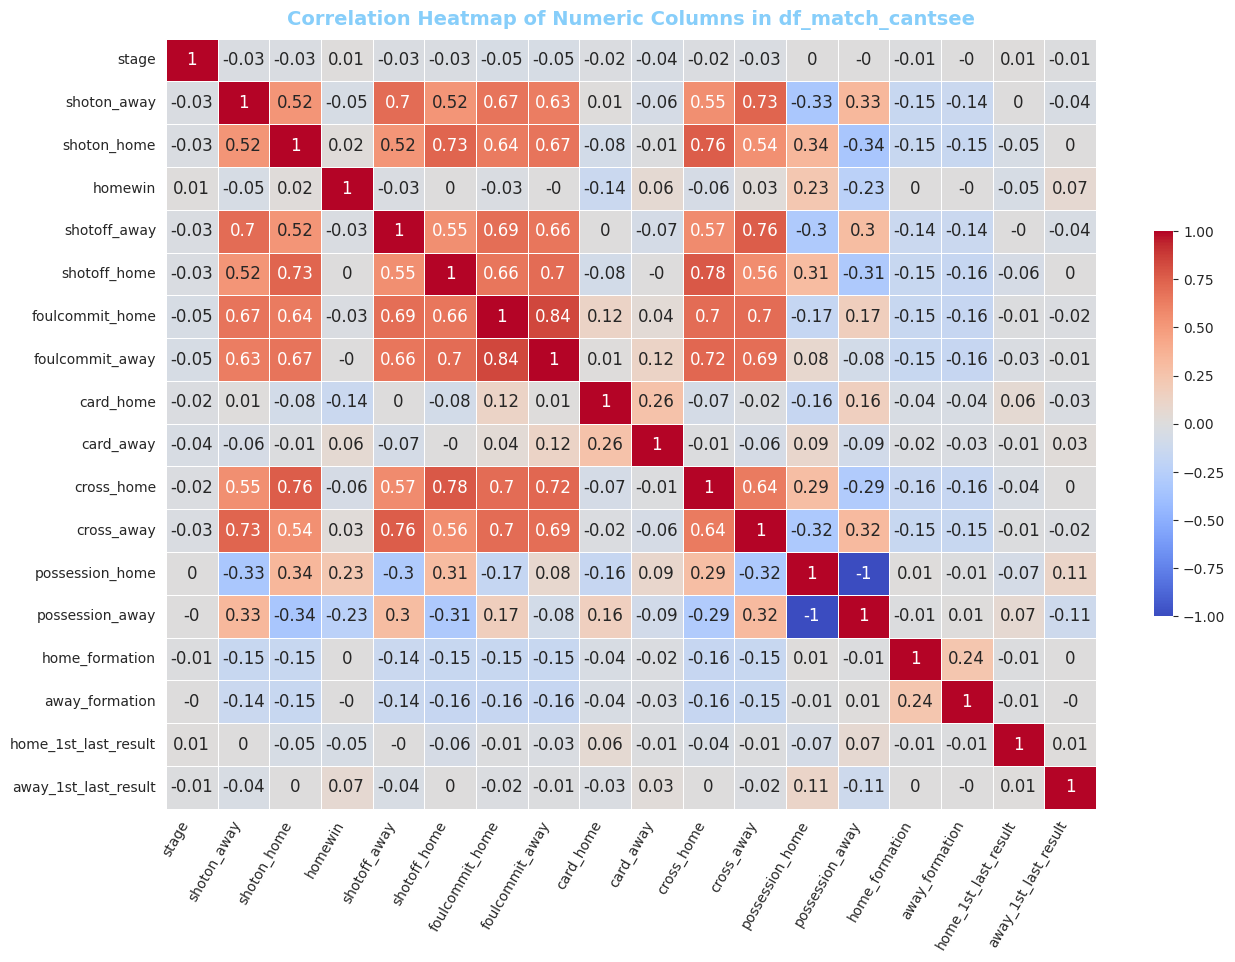

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# as we do not need the following columns to be plotted in heatmap: country_id	season	stage	date	home_team_api_id	away_team_api_id
corr = df_match_cantsee.corr(numeric_only=True)

# round to 2 decimal points for easy display
corr = np.round(corr, 2)
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, annot_kws={'fontsize': 12}, cbar_kws={'shrink': 0.5})
plt.title("Correlation Heatmap of Numeric Columns in df_match_cantsee", fontweight='bold', fontsize=14, pad=10, color='#87CEFA')
plt.xticks(rotation=60, ha='right', rotation_mode='default')
plt.show()

## Model Accepted
- We accept that the pipeline we established is significantly better than simple coorelation that can be derived from any of the features to homewin.
- Our model predicts right 49.2 percent of the times whereas simple coorealtion with most coorelated feature would have been potentially right only 23 percent of the times.

- Alternatively, we could also have rejected the model as the home team wins 45 percent of the times, and if we only predict on every match that home team wins, then we could already get 45 percent acuracy.

#### Scope for improvement:

- The model reults are subtantially improved in accuracy by using the betting odds data (accuracy rises to above 80 percent).
- it could be argued that the betting odds data by itself has been generated by well-trained machine learning models and hence we are essentially generating a result based on hidden models if we use that feature.

### Limitations:

- The data-set was far from ideal.
- The data-features were limited.
- Dictionary to the data was not available as a reference.
- Structure of data was not available.
- I did not have any domain knowledge about football (I did not know even the basics: how long is football game, how many teams etc) before this project.

## Caution: 

This is at best a learning project, rather than a production project. The challenge is just to understand what you need to do, rather than delivering good machine learning models, for which this data would both be insufficient and ineffecient.

## Google Looker Charts

3 kind of charts have been shown on this data in Looker Studio (formerly Google Data Studio)
[Go to link  to view the charts](https://lookerstudio.google.com/reporting/8255b844-5339-4ea5-895a-e73e8f625c7e)